# NBA DFS  Capstone Part 2 Regression Analysis
### Gia Nguyen
After clustering analysis Part 1 of the capstone, we will now move on to training and predicting fantasy points based on each player individual stats after we engineer a new feature known as DvC (defense vs cluster ratio) that we hypothesize to have high explanatory power and predictive ability for that player's performance on a certain matchup versus a particular team

## DvC Ratio 

In [1]:
# Import Necessary Packages
import pandas as pd
import numpy as np

In [2]:
# Load NBA game data for each game for each player purchased from rotoguru.com 
nbastatsfile = "/Users/kaizen/Data Science/Capstone/After Data Update/Rotoguru_GameData_1_28_18.csv"
data = pd.read_csv(nbastatsfile, low_memory=False)

#### EDA

In [3]:
# Examine the GAME DATA here that we will use to combine with our PLAYER DATA to train and predict FP
data.head(10)

,GID,"Last, First",First Last,Date,Team,Opp,H/A,GameID,GTime(ET),Team pts,...,DK Sal,DK Change,DD Sal,DD Change,YH Sal,YH Change,FD pos,DK pos,DD pos,YH pos
0,5153,"Mason III, Frank",Frank Mason III,20180128.0,sac,sas,A,20180128-sac-sas,19.0,98.0,...,3700.0,0.0,NaN,NaN,10.0,0.0,1.0,1.0,NaN,1.0
1,5153,"Mason III, Frank",Frank Mason III,20180125.0,sac,mia,A,20180125-sac-mia,19.5,89.0,...,3700.0,0.0,NaN,NaN,10.0,0.0,1.0,1.0,NaN,1.0
2,5153,"Mason III, Frank",Frank Mason III,20180123.0,sac,orl,A,20180123-sac-orl,19.0,105.0,...,3700.0,0.0,NaN,NaN,10.0,0.0,1.0,1.0,NaN,1.0
3,5153,"Mason III, Frank",Frank Mason III,20180122.0,sac,cha,A,20180122-sac-cha,19.0,107.0,...,3700.0,0.0,NaN,NaN,10.0,0.0,1.0,1.0,NaN,1.0
4,5153,"Mason III, Frank",Frank Mason III,20180119.0,sac,mem,A,20180119-sac-mem,20.0,88.0,...,3700.0,0.0,NaN,NaN,10.0,0.0,1.0,1.0,NaN,1.0
5,5153,"Mason III, Frank",Frank Mason III,20180117.0,sac,uta,H,20180117-uta-sac,22.0,105.0,...,3700.0,0.0,NaN,NaN,10.0,0.0,1.0,1.0,NaN,1.0
6,5153,"Mason III, Frank",Frank Mason III,20180115.0,sac,okc,A,20180115-sac-okc,20.0,88.0,...,3700.0,0.0,NaN,NaN,10.0,0.0,1.0,1.0,NaN,1.0
7,5153,"Mason III, Frank",Frank Mason III,20180113.0,sac,lac,A,20180113-sac-lac,15.5,105.0,...,3700.0,0.0,NaN,NaN,10.0,0.0,1.0,1.0,NaN,1.0
8,5153,"Mason III, Frank",Frank Mason III,20180111.0,sac,lac,H,20180111-lac-sac,22.0,115.0,...,3700.0,0.0,NaN,NaN,10.0,0.0,1.0,12.0,NaN,1.0
9,5153,"Mason III, Frank",Frank Mason III,20180109.0,sac,lal,A,20180109-sac-lal,22.5,86.0,...,3700.0,0.0,NaN,NaN,10.0,0.0,1.0,12.0,NaN,1.0


In [4]:
data.shape

(24655, 34)

In [5]:
# Adjust viewing limits
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [6]:
data.columns

Index(['GID', 'Last, First', 'First  Last', 'Date', 'Team', 'Opp', 'H/A', 'GameID', 'GTime(ET)', 'Team pts', 'Opp pts', 'Start', 'Minutes', 'GP', 'active', 'FDP', 'DKP', 'DDP', 'YHP', 'Stats', 'DoubleD', 'TripleD', 'FD Sal', 'FD Change', 'DK Sal', 'DK Change', 'DD Sal', 'DD Change', 'YH Sal', 'YH Change', 'FD pos', 'DK pos', 'DD pos', 'YH pos'], dtype='object')

In [7]:
# Grab the necessary columns for Fanduel Fantasy Points analysis 
fd_dvc = data[['First  Last','Date', 'Team', 'Opp', 'FD pos', 'FDP', 'FD Sal']]
fd_dvc.head()
# Note the positions are as follows:
# PG=1.0 SG=2.0  SF=3.0  PF=4.0  C=5.0

,First Last,Date,Team,Opp,FD pos,FDP,FD Sal
0,Frank Mason III,20180128.0,sac,sas,1.0,0.0,4000.0
1,Frank Mason III,20180125.0,sac,mia,1.0,0.0,4000.0
2,Frank Mason III,20180123.0,sac,orl,1.0,0.0,4000.0
3,Frank Mason III,20180122.0,sac,cha,1.0,0.0,4000.0
4,Frank Mason III,20180119.0,sac,mem,1.0,0.0,4000.0


#### Load and merge the cluster feature column 

Now that we have the game data with actual fantasy points results from Fanduel (FDP) from each game for each player with corresponding dates, opponents, and Fanduel salaries, we will add in the cluster column from our Clustering Analysis Python Notebook to engineer the feature, DvC ratios, for each cluster vs each NBA team, represented as a percentage change. 

In [8]:
# Read in player data file with player stats and cluster types saved from Part 1 of clustering analysis
player_data_file = '/Users/kaizen/Data Science/Capstone/all_players_with_clusters.csv'
player_data = pd.read_csv(player_data_file)

In [9]:
player_data.head()

,Unnamed: 0,PLAYER,POS,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PLUSMINUS,2ndPTS,FBPs,PITP,OppPTSOFFTO,Opp2ndPTS,OppFBPs,OppPITP,BLKA,PFD,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE,%FGA2PT,%FGA3PT,%PTS2PT,%PTS2PTMR,%PTS3PT,%PTSFBPs,%PTSFT,%PTSOffTO,%PTSPITP,2FGM%AST,2FGM%UAST,3FGM%AST,3FGM%UAST,FGM%AST,FGM%UAST,PERIPHERAL,Cluster
0,161,Giannis Antetokounmpo,PF,MIL,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1,3
1,390,James Harden,SG,HOU,28,32,25,7,36.3,32.4,9.7,21.3,45.6,4.3,10.8,39.4,8.8,10.2,86.5,0.5,4.7,5.2,9.2,4.4,1.8,0.5,2.7,55.0,13,2,8.0,1.8,2.1,9.5,13.7,8.6,9.9,35.1,1.3,7.1,115.9,105.8,10.2,45.2,2.09,23.3,1.6,14.7,8.2,11.1,55.6,63.0,36.0,101.71,19.3,49.3,50.7,33.5,4.2,39.3,6.5,27.2,15.3,29.3,12.6,87.4,30.1,69.9,20.3,79.7,22.6,4
2,160,LeBron James,PF,CLE,33,34,24,10,37.4,28.1,10.7,18.9,56.5,2.1,5.1,40.6,4.6,5.9,77.7,1.2,7.0,8.1,9.1,4.4,1.4,1.1,1.7,54.8,22,6,3.1,2.4,3.5,14.2,12.5,9.6,8.9,35.9,0.8,5.0,114.2,110.5,3.7,43.8,2.10,26.1,3.8,20.9,12.6,12.4,62.0,65.2,31.1,98.34,19.9,72.8,27.2,61.3,10.7,22.3,12.4,16.4,15.7,50.6,29.7,70.3,33.8,66.2,30.5,69.5,26.7,7
3,243,Russell Westbrook,PG,OKC,29,34,19,15,36.3,23.9,8.6,20.6,41.6,1.6,5.0,31.6,5.1,7.1,71.8,1.7,7.6,9.4,9.9,4.5,2.1,0.2,2.6,52.3,22,11,4.7,2.4,4.9,9.5,11.9,8.4,6.9,30.8,1.1,5.7,106.7,101.0,5.6,46.6,2.22,26.0,5.2,24.6,14.5,11.7,45.4,50.2,33.4,98.63,18.2,75.6,24.4,58.7,18.7,20.0,20.6,21.3,22.1,40.0,15.1,84.9,37.0,63.0,19.2,80.8,28.4,4
4,82,DeMarcus Cousins,C,NOP,27,33,17,16,35.2,25.9,8.9,18.6,47.8,2.2,6.2,35.3,6.0,8.1,73.8,2.1,10.0,12.1,5.2,5.1,1.5,1.5,3.7,52.0,24,1,0.0,3.3,1.6,12.1,13.6,9.3,10.6,33.2,1.4,7.6,107.9,107.9,0.0,24.7,1.02,16.0,7.0,31.7,19.7,15.7,53.7,58.5,34.0,100.81,16.7,66.7,33.3,51.7,5.1,25.3,6.1,23.0,12.9,46.5,40.3,59.7,93.1,6.9,53.2,46.8,26.1,5


In [10]:
# We extract just the player name and cluster to be merged to the fd_dvc dataframe
cluster_data = player_data[['PLAYER', 'Cluster']]
cluster_data.head()

,PLAYER,Cluster
0,Giannis Antetokounmpo,3
1,James Harden,4
2,LeBron James,7
3,Russell Westbrook,4
4,DeMarcus Cousins,5


In [11]:
cluster_data.shape

(408, 2)

In [12]:
# Change the "First Last" column to "PLAYER" for merging
fd_dvc2 = fd_dvc.rename(columns={'First  Last':'PLAYER'})
fd_dvc2.head()

,PLAYER,Date,Team,Opp,FD pos,FDP,FD Sal
0,Frank Mason III,20180128.0,sac,sas,1.0,0.0,4000.0
1,Frank Mason III,20180125.0,sac,mia,1.0,0.0,4000.0
2,Frank Mason III,20180123.0,sac,orl,1.0,0.0,4000.0
3,Frank Mason III,20180122.0,sac,cha,1.0,0.0,4000.0
4,Frank Mason III,20180119.0,sac,mem,1.0,0.0,4000.0


In [13]:
fd_dvc2.shape

(24655, 7)

In [14]:
# Merge the player data to the game data to add cluster column
alldata = pd.merge(cluster_data, fd_dvc2)
alldata.head()

,PLAYER,Cluster,Date,Team,Opp,FD pos,FDP,FD Sal
0,Giannis Antetokounmpo,3,20180129.0,mil,phi,3.0,NaN,11600.0
1,Giannis Antetokounmpo,3,20180128.0,mil,chi,3.0,52.8,11600.0
2,Giannis Antetokounmpo,3,20180126.0,mil,bkn,3.0,78.1,11600.0
3,Giannis Antetokounmpo,3,20180122.0,mil,pho,3.0,0.0,11600.0
4,Giannis Antetokounmpo,3,20180120.0,mil,phi,3.0,0.0,11600.0


In [15]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18831 entries, 0 to 18830
Data columns (total 8 columns):
PLAYER     18831 non-null object
Cluster    18831 non-null int64
Date       18831 non-null float64
Team       18831 non-null object
Opp        18831 non-null object
FD pos     18674 non-null float64
FDP        18679 non-null float64
FD Sal     18674 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 1.3+ MB


#### NOTE

We notice that the merged dataframe has significantly decreased in data from 24655 to 18831 rows. From previous experience and domain expertise, we suspect that besides player injuries and players getting assigned to the minor league (previously D-league for development, G-league for Gatorade starting this season), this could be due the fact that there are player name differences from our two data sources:
Game Data from Rotoguru.com and
Player Data from NBA.com 

For example, Louis Williams on Rotoguru is spelled as Lou Williams on NBA.com, J.J. Redick is JJ Redick, or Otto Porter is Otto Porter Jr.

To fix this problem, we will create a dictionary for mapping to make the names consistent for a more uniform and complete analysis

In [16]:
# Create two lists to be used in NBA player names dictionary
rotoguru_names = ["Guillermo Hernangomez", "Johnny O'Bryant", 'DeAndre Bembry', "Louis Williams","Frank Mason III",
            "C.J. McCollum","Timothe Luwawu","Ishmael Smith","Nene Hilario","Joseph Young","Gary Payton",
            "James Ennis","P.J. Tucker","T.J. Warren","C.J. Miles","J.J. Redick","Jose Barea",
            "J.R. Smith","Derrick Jones","Otto Porter","Kelly Oubre","Derrick Jones","Larry Nance",]
nba_names = ["Willy Hernangomez","Johnny O'Bryant III","DeAndre' Bembry","Lou Williams","Frank Mason",
             "CJ McCollum","Timothe Luwawu-Cabarrot","Ish Smith","Nene","Joe Young","Gary Payton II",
             "James Ennis III","PJ Tucker","TJ Warren","CJ Miles","JJ Redick","J.J. Barea",
             "JR Smith","Derrick Jones Jr.","Otto Porter Jr.",]
names_dict = dict(zip(rotoguru_names, nba_names))
print(names_dict)

{'Guillermo Hernangomez': 'Willy Hernangomez', "Johnny O'Bryant": "Johnny O'Bryant III", 'DeAndre Bembry': "DeAndre' Bembry", 'Louis Williams': 'Lou Williams', 'Frank Mason III': 'Frank Mason', 'C.J. McCollum': 'CJ McCollum', 'Timothe Luwawu': 'Timothe Luwawu-Cabarrot', 'Ishmael Smith': 'Ish Smith', 'Nene Hilario': 'Nene', 'Joseph Young': 'Joe Young', 'Gary Payton': 'Gary Payton II', 'James Ennis': 'James Ennis III', 'P.J. Tucker': 'PJ Tucker', 'T.J. Warren': 'TJ Warren', 'C.J. Miles': 'CJ Miles', 'J.J. Redick': 'JJ Redick', 'Jose Barea': 'J.J. Barea', 'J.R. Smith': 'JR Smith', 'Derrick Jones': 'Derrick Jones Jr.', 'Otto Porter': 'Otto Porter Jr.'}


After formulating the dictionary, we replace the player data's player names from rotoguru (keys in names_dict)
to match the name designations from NBA.com (values in names_dict)

In [17]:
fd_dvc2.head(2)

,PLAYER,Date,Team,Opp,FD pos,FDP,FD Sal
0,Frank Mason III,20180128.0,sac,sas,1.0,0.0,4000.0
1,Frank Mason III,20180125.0,sac,mia,1.0,0.0,4000.0


In [18]:
# We then see that the new dataframe fd_dvc3 has the NBA designation 
# (Frank Mason from the rotoguru's Frank Mason III)
fd_dvc3 = fd_dvc2.replace({'PLAYER': names_dict})
fd_dvc3.head(2)

,PLAYER,Date,Team,Opp,FD pos,FDP,FD Sal
0,Frank Mason,20180128.0,sac,sas,1.0,0.0,4000.0
1,Frank Mason,20180125.0,sac,mia,1.0,0.0,4000.0


In [19]:
fd_dvc3.shape

(24655, 7)

In [20]:
# We then merge AGAIN the player data to the game data to add the cluster column
alldata2 = pd.merge(cluster_data, fd_dvc3)
alldata2.head()

,PLAYER,Cluster,Date,Team,Opp,FD pos,FDP,FD Sal
0,Giannis Antetokounmpo,3,20180129.0,mil,phi,3.0,NaN,11600.0
1,Giannis Antetokounmpo,3,20180128.0,mil,chi,3.0,52.8,11600.0
2,Giannis Antetokounmpo,3,20180126.0,mil,bkn,3.0,78.1,11600.0
3,Giannis Antetokounmpo,3,20180122.0,mil,pho,3.0,0.0,11600.0
4,Giannis Antetokounmpo,3,20180120.0,mil,phi,3.0,0.0,11600.0


In [21]:
# We see below that we added back about 1000 rows of data, the rest of the missing data is likely due to 
# a lack of cluster types for players not being active such as having been assigned to G-league
# or is currently on the injury list, or they are have been removed due to filtering during clustering analysis
# for not playing enough minutes or games 
alldata2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19787 entries, 0 to 19786
Data columns (total 8 columns):
PLAYER     19787 non-null object
Cluster    19787 non-null int64
Date       19787 non-null float64
Team       19787 non-null object
Opp        19787 non-null object
FD pos     19629 non-null float64
FDP        19626 non-null float64
FD Sal     19629 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 1.4+ MB


In [22]:
# We now add a column 'FDexp' for the Fanduel expected FP performance based on Fanduel salary 
# FDexp = salary / 1000 * 5 
alldata2['FDexp'] = alldata['FD Sal'] / 1000 * 5 
alldata2.head()

,PLAYER,Cluster,Date,Team,Opp,FD pos,FDP,FD Sal,FDexp
0,Giannis Antetokounmpo,3,20180129.0,mil,phi,3.0,NaN,11600.0,58.0
1,Giannis Antetokounmpo,3,20180128.0,mil,chi,3.0,52.8,11600.0,58.0
2,Giannis Antetokounmpo,3,20180126.0,mil,bkn,3.0,78.1,11600.0,58.0
3,Giannis Antetokounmpo,3,20180122.0,mil,pho,3.0,0.0,11600.0,58.0
4,Giannis Antetokounmpo,3,20180120.0,mil,phi,3.0,0.0,11600.0,58.0


In [23]:
# Calculate the difference from salary expected FP compare to actual FP produced for each player, Diff 
alldata2['Diff'] = ((alldata2['FDP'] - alldata2['FDexp'])/ alldata2['FDexp'])
alldata2

,PLAYER,Cluster,Date,Team,Opp,FD pos,FDP,FD Sal,FDexp,Diff
0,Giannis Antetokounmpo,3,20180129.0,mil,phi,3.0,NaN,11600.0,58.0,NaN
1,Giannis Antetokounmpo,3,20180128.0,mil,chi,3.0,52.8,11600.0,58.0,-0.089655
2,Giannis Antetokounmpo,3,20180126.0,mil,bkn,3.0,78.1,11600.0,58.0,0.346552
3,Giannis Antetokounmpo,3,20180122.0,mil,pho,3.0,0.0,11600.0,58.0,-1.000000
4,Giannis Antetokounmpo,3,20180120.0,mil,phi,3.0,0.0,11600.0,58.0,-1.000000
5,Giannis Antetokounmpo,3,20180117.0,mil,mia,3.0,54.0,11600.0,58.0,-0.068966
6,Giannis Antetokounmpo,3,20180115.0,mil,was,3.0,63.0,10500.0,52.5,0.200000
7,Giannis Antetokounmpo,3,20180114.0,mil,mia,3.0,31.7,10900.0,54.5,-0.418349
8,Giannis Antetokounmpo,3,20180112.0,mil,gsw,3.0,37.4,10800.0,54.0,-0.307407
9,Giannis Antetokounmpo,3,20180110.0,mil,orl,3.0,36.9,11700.0,58.5,-0.369231


In [24]:
# From EDA, we see that there are missing values for players in the Diff column 
alldata2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19787 entries, 0 to 19786
Data columns (total 10 columns):
PLAYER     19787 non-null object
Cluster    19787 non-null int64
Date       19787 non-null float64
Team       19787 non-null object
Opp        19787 non-null object
FD pos     19629 non-null float64
FDP        19626 non-null float64
FD Sal     19629 non-null float64
FDexp      18674 non-null float64
Diff       18525 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 1.7+ MB


In [25]:
# We drop these values to yield 18,398 rows of data for each player who score more than 5 FP/game 
alldata2dropna = alldata2.dropna()

In [26]:
alldata2dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18399 entries, 1 to 18829
Data columns (total 10 columns):
PLAYER     18399 non-null object
Cluster    18399 non-null int64
Date       18399 non-null float64
Team       18399 non-null object
Opp        18399 non-null object
FD pos     18399 non-null float64
FDP        18399 non-null float64
FD Sal     18399 non-null float64
FDexp      18399 non-null float64
Diff       18399 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 1.5+ MB


In [27]:
# Summary statistics for the Diff column 
alldata2dropna.Diff.describe()

count    18399.000000
mean        -0.340727
std          0.523781
min         -1.200000
25%         -0.880163
50%         -0.326667
75%          0.020000
max          2.326667
Name: Diff, dtype: float64

In [28]:
alldata2dropna

,PLAYER,Cluster,Date,Team,Opp,FD pos,FDP,FD Sal,FDexp,Diff
1,Giannis Antetokounmpo,3,20180128.0,mil,chi,3.0,52.8,11600.0,58.0,-0.089655
2,Giannis Antetokounmpo,3,20180126.0,mil,bkn,3.0,78.1,11600.0,58.0,0.346552
3,Giannis Antetokounmpo,3,20180122.0,mil,pho,3.0,0.0,11600.0,58.0,-1.000000
4,Giannis Antetokounmpo,3,20180120.0,mil,phi,3.0,0.0,11600.0,58.0,-1.000000
5,Giannis Antetokounmpo,3,20180117.0,mil,mia,3.0,54.0,11600.0,58.0,-0.068966
6,Giannis Antetokounmpo,3,20180115.0,mil,was,3.0,63.0,10500.0,52.5,0.200000
7,Giannis Antetokounmpo,3,20180114.0,mil,mia,3.0,31.7,10900.0,54.5,-0.418349
8,Giannis Antetokounmpo,3,20180112.0,mil,gsw,3.0,37.4,10800.0,54.0,-0.307407
9,Giannis Antetokounmpo,3,20180110.0,mil,orl,3.0,36.9,11700.0,58.5,-0.369231
10,Giannis Antetokounmpo,3,20180108.0,mil,ind,3.0,34.9,11100.0,55.5,-0.371171


In [29]:
# Calculate and PercentChange column from Diff for easier interpretation
fd_dvc_change = alldata2dropna
fd_dvc_change['PercentChange'] = fd_dvc_change.Diff * 100
fd_dvc_change.head()

/Users/kaizen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,PLAYER,Cluster,Date,Team,Opp,FD pos,FDP,FD Sal,FDexp,Diff,PercentChange
1,Giannis Antetokounmpo,3,20180128.0,mil,chi,3.0,52.8,11600.0,58.0,-0.089655,-8.965517
2,Giannis Antetokounmpo,3,20180126.0,mil,bkn,3.0,78.1,11600.0,58.0,0.346552,34.655172
3,Giannis Antetokounmpo,3,20180122.0,mil,pho,3.0,0.0,11600.0,58.0,-1.000000,-100.000000
4,Giannis Antetokounmpo,3,20180120.0,mil,phi,3.0,0.0,11600.0,58.0,-1.000000,-100.000000
5,Giannis Antetokounmpo,3,20180117.0,mil,mia,3.0,54.0,11600.0,58.0,-0.068966,-6.896552


In [30]:
# Summary Statistics 
fd_dvc_change.PercentChange.describe()

count    18399.000000
mean       -34.072652
std         52.378067
min       -120.000000
25%        -88.016318
50%        -32.666667
75%          2.000000
max        232.666667
Name: PercentChange, dtype: float64

In [31]:
# Produce a pivot table with the DvC ratio to be used as a feature for our regression analysis 
fdpivot = pd.pivot_table(fd_dvc_change, index='Opp', columns='Cluster', values='PercentChange', aggfunc='mean')
fdpivot

Cluster,0,1,2,3,4,5,6,7
Opp,,,,,,,,
atl,-23.747689,-42.926098,-20.860654,-26.345221,-35.560800,-26.494687,-34.689011,-29.259379
bkn,-25.846610,-25.816549,-41.288294,-35.115442,-32.663882,-25.303667,-27.309769,-44.970225
bos,-39.083094,-39.576258,-37.002549,-33.342318,-38.555856,-40.153684,-45.517607,-39.991345
cha,-29.008078,-33.805422,-29.932360,-30.759872,-40.156158,-37.562707,-40.071839,-22.351856
chi,-23.793568,-34.083052,-24.447759,-30.520169,-34.707768,-28.262719,-39.705665,-30.051887
cle,-27.565639,-47.396415,-28.283309,-28.893235,-33.985626,-37.551728,-32.407458,-11.111174
dal,-38.916929,-38.037375,-39.383412,-35.884601,-31.806729,-30.554450,-38.933241,-41.675908
den,-25.356365,-30.262286,-38.395951,-34.531875,-23.322881,-33.163677,-31.009354,-35.823857
det,-33.627622,-48.612128,-31.664346,-32.930138,-41.387163,-26.780250,-40.323296,-36.693613


In [32]:
# Examining the pivot table, the percent changes do not seem to be correct since there are no positive numbers
# Meaning there are no single cluster type who outperforms salary expectation vs any single team
# This is likely to be wrong and indicate a flaw in our data manipulation and analysis 
pho = fd_dvc_change[(fd_dvc_change.Opp == 'pho') & (fd_dvc_change.Cluster == 7)]
pho

,PLAYER,Cluster,Date,Team,Opp,FD pos,FDP,FD Sal,FDexp,Diff,PercentChange
451,Ben Simmons,7,20171231.0,phi,pho,4.0,53.8,8700.0,43.5,0.236782,23.678161
464,Ben Simmons,7,20171204.0,phi,pho,4.0,55.1,10500.0,52.5,0.049524,4.952381
755,Blake Griffin,7,20171220.0,lac,pho,4.0,0.0,9700.0,48.5,-1.000000,-100.000000
783,Blake Griffin,7,20171021.0,lac,pho,4.0,47.6,9800.0,49.0,-0.028571,-2.857143
2098,Al Horford,7,20171202.0,bos,pho,5.0,38.5,7700.0,38.5,0.000000,0.000000
4697,James Johnson,7,20171108.0,mia,pho,4.0,35.9,6200.0,24.5,0.465306,46.530612
6057,Kyle Anderson,7,20180105.0,sas,pho,3.0,25.0,5000.0,26.5,-0.056604,-5.660377
6070,Kyle Anderson,7,20171209.0,sas,pho,3.0,0.0,5300.0,22.5,-1.000000,-100.000000
6087,Kyle Anderson,7,20171105.0,sas,pho,3.0,18.8,5000.0,24.0,-0.216667,-21.666667
8149,Lance Stephenson,7,20180124.0,ind,pho,3.0,31.8,3900.0,24.0,0.325000,32.500000


In [33]:
# We look closer at a team who we know has been underperforming this season and is particularly weak against
# cluster 7 (floor spacers) and should have a positive percent change or at least one much less than the mean
# of -34
pho.PercentChange.mean()

-13.786393546507346

In [34]:
# We suspect this could be due to the times when players are out and produce actual 0.0 points
# which will skew the data
# Remove all FDP with 0.0 points from dataframe, we filter out any players with less than 5 FP to remove outliers 
fd_dvc_change2 = fd_dvc_change[fd_dvc_change.FDP > 5]
fd_dvc_change2.describe()

,Cluster,Date,FD pos,FDP,FD Sal,FDexp,Diff,PercentChange
count,12978.000000,1.297800e+04,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000
mean,3.278857,2.017342e+07,2.955617,23.339112,5187.709894,25.530281,-0.080330,-8.032959
std,2.117963,3.909293e+03,1.393089,12.756131,1977.904329,9.985405,0.395266,39.526612
min,0.000000,2.017102e+07,1.000000,5.100000,3000.000000,15.000000,-0.898361,-89.836066
25%,2.000000,2.017111e+07,2.000000,13.500000,3600.000000,17.500000,-0.369111,-36.911058
50%,3.000000,2.017121e+07,3.000000,21.100000,4600.000000,22.000000,-0.123014,-12.301387
75%,5.000000,2.018010e+07,4.000000,30.600000,6300.000000,31.000000,0.147112,14.711205
max,7.000000,2.018013e+07,5.000000,97.800000,12600.000000,63.000000,2.326667,232.666667


In [35]:
fd_dvc_change2.PercentChange.describe()

count    12978.000000
mean        -8.032959
std         39.526612
min        -89.836066
25%        -36.911058
50%        -12.301387
75%         14.711205
max        232.666667
Name: PercentChange, dtype: float64

In [36]:
# Now we produce another pivot table with the DvC ratio to be used as a feature for our regression analysis 
# We double check to see that Phoenix Suns is indeed weak against cluster 7 and produce a huge 19% change 
# in performance based on salary expectations and DvC ratio alone 
fdpivot2 = pd.pivot_table(fd_dvc_change2, index='Opp', columns='Cluster', values='PercentChange', aggfunc='mean')
fdpivot2

Cluster,0,1,2,3,4,5,6,7
Opp,,,,,,,,
atl,-4.838203,-6.976096,-1.599255,-3.319540,0.516351,-7.934451,-4.867789,8.929856
bkn,-4.244804,-0.647164,-21.805270,-12.757394,-7.216108,0.515003,-6.031961,-11.772300
bos,-14.902441,-15.424284,-14.642089,-13.671533,-10.532787,-10.853638,-17.597931,-16.035358
cha,-9.495276,-7.035029,0.657147,-5.699747,-2.342926,-14.910492,-8.696839,-0.610376
chi,-0.768358,-3.093893,-5.784622,-9.784139,-1.886228,-3.504080,-8.203989,4.940379
cle,-4.693220,-8.563433,-6.110708,-0.001934,4.788608,-9.958782,-3.593446,7.602264
dal,-16.550820,-2.535017,-17.312827,-10.711790,-2.129239,-4.401283,-14.611955,-8.698316
den,-1.277622,-2.055061,-19.759403,-4.384053,-6.484356,-5.391369,-10.370906,-10.153400
det,-11.493979,-18.628581,-15.085162,-4.590767,-13.098035,-6.078009,-7.735642,-15.483160


#### Example Interpretations 

On average, cluster type Ball Handlers such as Damian Lillard, Kyrie Irving, Kemba Walker, Lonzo Ball) will perform -1.37% less than salary expectation vs Atlanta Hawks

And cluster 7 (Floor Spacers such as Lebron James, Ben Simmons, Blake Griffin, Dwyane Wade) will perform a whopping 18.97% better than salary expectaion vs the Phoenix Suns

NOTE: most DvC ratios are negative 

In [37]:
# To add DvC to a column as feature, we convert the Fanduel pivot table to a dictionary 
fd_dict = fdpivot2.to_dict()

In [38]:
fd_dict

{0: {'atl': -4.838202868282979,
  'bkn': -4.244804308985144,
  'bos': -14.902441103110634,
  'cha': -9.49527631673199,
  'chi': -0.7683584421881439,
  'cle': -4.693219664446034,
  'dal': -16.550819844076894,
  'den': -1.2776220022334022,
  'det': -11.493979227143061,
  'gsw': -4.8104059003097595,
  'hou': -9.947095602705518,
  'ind': -0.5091989481879393,
  'lac': -3.8450015461884113,
  'lal': -2.814194997968287,
  'mem': -9.014091077691342,
  'mia': -9.859600024942631,
  'mil': -3.637116033695611,
  'min': 5.706149570103672,
  'nor': 6.899692331539489,
  'nyk': -4.08703092944437,
  'okc': -10.542964008118402,
  'orl': -3.3157333119233092,
  'phi': -5.855961622082304,
  'pho': -6.295814786118706,
  'por': -9.11976679061775,
  'sac': -9.204864082284162,
  'sas': -11.764843849112824,
  'tor': -5.798024989548852,
  'uta': -14.197181256287443,
  'was': -3.2347647618976763},
 1: {'atl': -6.976096315891112,
  'bkn': -0.6471635527911879,
  'bos': -15.42428355620874,
  'cha': -7.035029291199932

In [39]:
fd_dvc_change2.head()

,PLAYER,Cluster,Date,Team,Opp,FD pos,FDP,FD Sal,FDexp,Diff,PercentChange
1,Giannis Antetokounmpo,3,20180128.0,mil,chi,3.0,52.8,11600.0,58.0,-0.089655,-8.965517
2,Giannis Antetokounmpo,3,20180126.0,mil,bkn,3.0,78.1,11600.0,58.0,0.346552,34.655172
5,Giannis Antetokounmpo,3,20180117.0,mil,mia,3.0,54.0,11600.0,58.0,-0.068966,-6.896552
6,Giannis Antetokounmpo,3,20180115.0,mil,was,3.0,63.0,10500.0,52.5,0.200000,20.000000
7,Giannis Antetokounmpo,3,20180114.0,mil,mia,3.0,31.7,10900.0,54.5,-0.418349,-41.834862


In [40]:
# We then map the values from the dictionary to create a new column DvC 
# using the Cluster and Opp columns as keys for the values of PercentChange
fd_dvc_change2['DvC'] = fd_dvc_change2.apply(lambda x: fd_dict[x.Cluster][x.Opp], axis=1)

/Users/kaizen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
# We double check the DvC column for correct values by looking at the pivot table above 
fd_dvc_change2.head()

,PLAYER,Cluster,Date,Team,Opp,FD pos,FDP,FD Sal,FDexp,Diff,PercentChange,DvC
1,Giannis Antetokounmpo,3,20180128.0,mil,chi,3.0,52.8,11600.0,58.0,-0.089655,-8.965517,-9.784139
2,Giannis Antetokounmpo,3,20180126.0,mil,bkn,3.0,78.1,11600.0,58.0,0.346552,34.655172,-12.757394
5,Giannis Antetokounmpo,3,20180117.0,mil,mia,3.0,54.0,11600.0,58.0,-0.068966,-6.896552,-12.830732
6,Giannis Antetokounmpo,3,20180115.0,mil,was,3.0,63.0,10500.0,52.5,0.200000,20.000000,1.462796
7,Giannis Antetokounmpo,3,20180114.0,mil,mia,3.0,31.7,10900.0,54.5,-0.418349,-41.834862,-12.830732


In [42]:
# Cluster 1 (elite bigs like Nikola Jokic) players perform -5.65% vs Portland 
fd_dvc_change2[1000:1001]

,PLAYER,Cluster,Date,Team,Opp,FD pos,FDP,FD Sal,FDexp,Diff,PercentChange,DvC
1143,Paul George,2,20180113.0,okc,cha,3.0,30.6,7500.0,37.5,-0.184,-18.4,0.657147


In [43]:
# Cluster 0 (ball handlers like Nicolas Batum) players perform 7.46% vs Minnesota
fd_dvc_change2[4750:4765]

,PLAYER,Cluster,Date,Team,Opp,FD pos,FDP,FD Sal,FDexp,Diff,PercentChange,DvC
5563,Nicolas Batum,0,20171227.0,cha,bos,2.0,25.1,6100.0,31.5,-0.203175,-20.317460,-14.902441
5564,Nicolas Batum,0,20171223.0,cha,mil,2.0,35.0,6000.0,32.0,0.093750,9.375000,-3.637116
5565,Nicolas Batum,0,20171222.0,cha,mil,2.0,21.2,6000.0,29.0,-0.268966,-26.896552,-3.637116
5566,Nicolas Batum,0,20171220.0,cha,tor,2.0,8.9,6300.0,27.5,-0.676364,-67.636364,-5.798025
5567,Nicolas Batum,0,20171218.0,cha,nyk,2.0,28.8,6400.0,30.0,-0.040000,-4.000000,-4.087031
5568,Nicolas Batum,0,20171216.0,cha,por,2.0,35.3,6000.0,31.5,0.120635,12.063492,-9.119767
5569,Nicolas Batum,0,20171215.0,cha,mia,2.0,28.6,6000.0,30.0,-0.046667,-4.666667,-9.859600
5570,Nicolas Batum,0,20171213.0,cha,hou,2.0,24.3,6400.0,30.0,-0.190000,-19.000000,-9.947096
5572,Nicolas Batum,0,20171209.0,cha,lal,2.0,10.9,6400.0,28.0,-0.610714,-61.071429,-2.814195
5573,Nicolas Batum,0,20171208.0,cha,chi,2.0,35.2,6400.0,30.5,0.154098,15.409836,-0.768358


## Regression Analysis

After the DvC feature engineering, we will now combine this new data along with the game data from rotoguru to our player data for regression analysis

In [44]:
player_data.head()

,Unnamed: 0,PLAYER,POS,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PLUSMINUS,2ndPTS,FBPs,PITP,OppPTSOFFTO,Opp2ndPTS,OppFBPs,OppPITP,BLKA,PFD,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE,%FGA2PT,%FGA3PT,%PTS2PT,%PTS2PTMR,%PTS3PT,%PTSFBPs,%PTSFT,%PTSOffTO,%PTSPITP,2FGM%AST,2FGM%UAST,3FGM%AST,3FGM%UAST,FGM%AST,FGM%UAST,PERIPHERAL,Cluster
0,161,Giannis Antetokounmpo,PF,MIL,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1,3
1,390,James Harden,SG,HOU,28,32,25,7,36.3,32.4,9.7,21.3,45.6,4.3,10.8,39.4,8.8,10.2,86.5,0.5,4.7,5.2,9.2,4.4,1.8,0.5,2.7,55.0,13,2,8.0,1.8,2.1,9.5,13.7,8.6,9.9,35.1,1.3,7.1,115.9,105.8,10.2,45.2,2.09,23.3,1.6,14.7,8.2,11.1,55.6,63.0,36.0,101.71,19.3,49.3,50.7,33.5,4.2,39.3,6.5,27.2,15.3,29.3,12.6,87.4,30.1,69.9,20.3,79.7,22.6,4
2,160,LeBron James,PF,CLE,33,34,24,10,37.4,28.1,10.7,18.9,56.5,2.1,5.1,40.6,4.6,5.9,77.7,1.2,7.0,8.1,9.1,4.4,1.4,1.1,1.7,54.8,22,6,3.1,2.4,3.5,14.2,12.5,9.6,8.9,35.9,0.8,5.0,114.2,110.5,3.7,43.8,2.10,26.1,3.8,20.9,12.6,12.4,62.0,65.2,31.1,98.34,19.9,72.8,27.2,61.3,10.7,22.3,12.4,16.4,15.7,50.6,29.7,70.3,33.8,66.2,30.5,69.5,26.7,7
3,243,Russell Westbrook,PG,OKC,29,34,19,15,36.3,23.9,8.6,20.6,41.6,1.6,5.0,31.6,5.1,7.1,71.8,1.7,7.6,9.4,9.9,4.5,2.1,0.2,2.6,52.3,22,11,4.7,2.4,4.9,9.5,11.9,8.4,6.9,30.8,1.1,5.7,106.7,101.0,5.6,46.6,2.22,26.0,5.2,24.6,14.5,11.7,45.4,50.2,33.4,98.63,18.2,75.6,24.4,58.7,18.7,20.0,20.6,21.3,22.1,40.0,15.1,84.9,37.0,63.0,19.2,80.8,28.4,4
4,82,DeMarcus Cousins,C,NOP,27,33,17,16,35.2,25.9,8.9,18.6,47.8,2.2,6.2,35.3,6.0,8.1,73.8,2.1,10.0,12.1,5.2,5.1,1.5,1.5,3.7,52.0,24,1,0.0,3.3,1.6,12.1,13.6,9.3,10.6,33.2,1.4,7.6,107.9,107.9,0.0,24.7,1.02,16.0,7.0,31.7,19.7,15.7,53.7,58.5,34.0,100.81,16.7,66.7,33.3,51.7,5.1,25.3,6.1,23.0,12.9,46.5,40.3,59.7,93.1,6.9,53.2,46.8,26.1,5


In [45]:
# Clean dataframes to prepare for merging 
player_data.columns

Index(['Unnamed: 0', 'PLAYER', 'POS', 'TEAM', 'AGE', 'GP', 'W', 'L', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', 'TD3', 'PLUSMINUS', '2ndPTS', 'FBPs', 'PITP', 'OppPTSOFFTO', 'Opp2ndPTS', 'OppFBPs', 'OppPITP', 'BLKA', 'PFD', 'OFFRTG', 'DEFRTG', 'NETRTG', 'AST%', 'AST/TO', 'AST Ratio', 'OREB%', 'DREB%', 'REB%', 'TO Ratio', 'eFG%', 'TS%', 'USG%', 'PACE', 'PIE', '%FGA2PT', '%FGA3PT', '%PTS2PT', '%PTS2PTMR', '%PTS3PT', '%PTSFBPs', '%PTSFT', '%PTSOffTO', '%PTSPITP', '2FGM%AST', '2FGM%UAST', '3FGM%AST', '3FGM%UAST', 'FGM%AST', 'FGM%UAST', 'PERIPHERAL', 'Cluster'], dtype='object')

In [46]:
playerdata2 = player_data.drop(['Unnamed: 0', 'POS', 'Cluster', 'TEAM'], axis=1)
playerdata2.head(2)

,PLAYER,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PLUSMINUS,2ndPTS,FBPs,PITP,OppPTSOFFTO,Opp2ndPTS,OppFBPs,OppPITP,BLKA,PFD,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE,%FGA2PT,%FGA3PT,%PTS2PT,%PTS2PTMR,%PTS3PT,%PTSFBPs,%PTSFT,%PTSOffTO,%PTSPITP,2FGM%AST,2FGM%UAST,3FGM%AST,3FGM%UAST,FGM%AST,FGM%UAST,PERIPHERAL
0,Giannis Antetokounmpo,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
1,James Harden,28,32,25,7,36.3,32.4,9.7,21.3,45.6,4.3,10.8,39.4,8.8,10.2,86.5,0.5,4.7,5.2,9.2,4.4,1.8,0.5,2.7,55.0,13,2,8.0,1.8,2.1,9.5,13.7,8.6,9.9,35.1,1.3,7.1,115.9,105.8,10.2,45.2,2.09,23.3,1.6,14.7,8.2,11.1,55.6,63.0,36.0,101.71,19.3,49.3,50.7,33.5,4.2,39.3,6.5,27.2,15.3,29.3,12.6,87.4,30.1,69.9,20.3,79.7,22.6


In [47]:
gamedata = fd_dvc_change2[['PLAYER', 'Cluster', 'Date', 'Opp', 'FDP', 'DvC']]
gamedata.head(2)

,PLAYER,Cluster,Date,Opp,FDP,DvC
1,Giannis Antetokounmpo,3,20180128.0,chi,52.8,-9.784139
2,Giannis Antetokounmpo,3,20180126.0,bkn,78.1,-12.757394


In [48]:
gamedata.shape

(12978, 6)

In [49]:
playerdata2.shape

(408, 68)

In [50]:
mergedf = gamedata.merge(playerdata2, on='PLAYER')
mergedf.head(100)

,PLAYER,Cluster,Date,Opp,FDP,DvC,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PLUSMINUS,2ndPTS,FBPs,PITP,OppPTSOFFTO,Opp2ndPTS,OppFBPs,OppPITP,BLKA,PFD,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE,%FGA2PT,%FGA3PT,%PTS2PT,%PTS2PTMR,%PTS3PT,%PTSFBPs,%PTSFT,%PTSOffTO,%PTSPITP,2FGM%AST,2FGM%UAST,3FGM%AST,3FGM%UAST,FGM%AST,FGM%UAST,PERIPHERAL
0,Giannis Antetokounmpo,3,20180128.0,chi,52.8,-9.784139,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
1,Giannis Antetokounmpo,3,20180126.0,bkn,78.1,-12.757394,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
2,Giannis Antetokounmpo,3,20180117.0,mia,54.0,-12.830732,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
3,Giannis Antetokounmpo,3,20180115.0,was,63.0,1.462796,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
4,Giannis Antetokounmpo,3,20180114.0,mia,31.7,-12.830732,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
5,Giannis Antetokounmpo,3,20180112.0,gsw,37.4,-5.194044,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
6,Giannis Antetokounmpo,3,20180110.0,orl,36.9,-10.579584,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
7,Giannis Antetokounmpo,3,20180108.0,ind,34.9,-11.325054,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
8,Giannis Antetokounmpo,3,20180106.0,was,64.9,1.462796,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
9,Giannis Antetokounmpo,3,20180105.0,tor,41.5,-21.375800,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,

In [51]:
mergedf.shape

(12978, 73)

### EDA

In [52]:
# Ensure that there are no outliers and exorbitant statistics 
mergedf.describe()

,Cluster,Date,FDP,DvC,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PLUSMINUS,2ndPTS,FBPs,PITP,OppPTSOFFTO,Opp2ndPTS,OppFBPs,OppPITP,BLKA,PFD,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE,%FGA2PT,%FGA3PT,%PTS2PT,%PTS2PTMR,%PTS3PT,%PTSFBPs,%PTSFT,%PTSOffTO,%PTSPITP,2FGM%AST,2FGM%UAST,3FGM%AST,3FGM%UAST,FGM%AST,FGM%UAST,PERIPHERAL
count,12978.000000,1.297800e+04,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000
mean,3.278857,2.017342e+07,23.339112,-8.032959,26.630991,29.121667,14.691016,14.430652,24.397943,10.899807,4.043165,8.767083,46.359693,1.063153,2.900015,31.193065,1.744768,2.275458,75.241894,0.991331,3.442896,4.433803,2.338827,1.463662,0.787710,0.492403,2.002080,22.099661,2.597396,0.121051,0.201441,1.267846,1.153637,4.573540,8.343766,6.203714,5.654862,22.241994,0.492950,2.092942,105.084874,105.047681,0.038835,14.094175,1.604447,16.494783,4.761866,15.740630,10.252789,10.924850,52.261774,55.501603,19.419579,99.330670,9.901541,67.297973,32.702219,55.433225,12.037779,29.375543,10.524210,15.195007,15.888835,43.393358,51.117252,48.868816,74.254030,13.017630,60.962028,39.038519,11.199854
std,2.117963,3.909293e+03,12.756131,6.078990,4.212947,5.863522,5.788594,5.247956,7.430663,5.927731,2.121363,4.472507,7.088740,0.856142,2.165088,14.450367,1.397367,1.730205,12.404053,0.821088,1.850319,2.481284,1.841086,0.845532,0.423356,0.429606,0.616374,10.105410,4.880742,0.837531,3.298225,0.871206,0.951427,2.953725,2.732831,2.019655,2.191040,7.247996,0.310305,1.390517,4.991491,4.108914,6.961337,8.924554,0.844756,7.822424,3.727462,6.338522,4.689484,3.183952,6.152374,5.709540,5.459497,2.647172,3.437659,20.525477,20.525487,18.437560,8.510048,20.212772,6.211495,6.185764,4.767854,19.443701,20.816980,20.815745,32.769749,17.154823,19.062041,19.061626,5.093235
min,0.000000,2.017102e+07,5.100000,-24.590870,19.000000,6.000000,0.000000,1.000000,5.500000,1.300000,0.300000,0.700000,26.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,0.700000,0.100000,0.000000,0.000000,0.000000,0.300000,5.200000,0.000000,0.000000,-7.400000,0.000000,0.000000,0.000000,1.400000,0.800000,0.300000,4.700000,0.000000,0.100000,84.300000,71.500000,-27.000000,2.400000,0.000000,2.700000,0.000000,5.100000,3.100000,0.000000,29.900000,36.600000,7.400000,91.610000,0.400000,13.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.900000
25%,2.000000,2.017111e+07,13.500000,-12.251533,23.000000,27.000000,10.000000,10.000000,18.300000,6.500000,2.400000,5.100000,41.700000,0.300000,1.100000,28.200000,0.800000,1.000000,68.500000,0.400000,2.100000,2.700000,1.000000,0.900000,0.500000,0.200000,1.600000,14.800000,0.000000,0.000000,-2.000000,0.700000,0.500000,2.300000,6.300000,4.700000,3.900000,16.300000,0.300000,1.100000,101.700000,102.700000,-4.100000,7.400000,1.000000,10.700000,1.900000,10.600000,6.300000,8.600000,48.400000,51.500000,15.600000,97.440000,7.500000,54.200000,18.000000,42.700000,5.100000,13.000000,6.200000,10.900000,13.000000,29.000000,34.500000,31.

In [53]:
mergedf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12978 entries, 0 to 12977
Data columns (total 73 columns):
PLAYER         12978 non-null object
Cluster        12978 non-null int64
Date           12978 non-null float64
Opp            12978 non-null object
FDP            12978 non-null float64
DvC            12978 non-null float64
AGE            12978 non-null int64
GP             12978 non-null int64
W              12978 non-null int64
L              12978 non-null int64
MIN            12978 non-null float64
PTS            12978 non-null float64
FGM            12978 non-null float64
FGA            12978 non-null float64
FG%            12978 non-null float64
3PM            12978 non-null float64
3PA            12978 non-null float64
3P%            12978 non-null float64
FTM            12978 non-null float64
FTA            12978 non-null float64
FT%            12978 non-null float64
OREB           12978 non-null float64
DREB           12978 non-null float64
REB            12978 non-null

In [54]:
# The mean Fanduel fantasy points is consistent with the baseline average salary of $5,000
# to match the baseline salary-adjusted expectation of 5000/1000 * 5 = 25 fantasy points expected value
# the minimum fantasy points should be higher than 5 as well to eliminate bench players who accumulate stats
# during garbage time and blowout games 
mergedf.FDP.describe()

count    12978.000000
mean        23.339112
std         12.756131
min          5.100000
25%         13.500000
50%         21.100000
75%         30.600000
max         97.800000
Name: FDP, dtype: float64

In [55]:
mergedf.head(2)

,PLAYER,Cluster,Date,Opp,FDP,DvC,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PLUSMINUS,2ndPTS,FBPs,PITP,OppPTSOFFTO,Opp2ndPTS,OppFBPs,OppPITP,BLKA,PFD,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE,%FGA2PT,%FGA3PT,%PTS2PT,%PTS2PTMR,%PTS3PT,%PTSFBPs,%PTSFT,%PTSOffTO,%PTSPITP,2FGM%AST,2FGM%UAST,3FGM%AST,3FGM%UAST,FGM%AST,FGM%UAST,PERIPHERAL
0,Giannis Antetokounmpo,3,20180128.0,chi,52.8,-9.784139,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
1,Giannis Antetokounmpo,3,20180126.0,bkn,78.1,-12.757394,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1


In [56]:
print(mergedf.Date.dtype)

float64


In [57]:
# Remove the trailing zeros in the Date column 
mergedf['Date'] = mergedf['Date'].astype(int)


In [58]:
# Convert teams to numbers in Opponent column 
nbateams = ["atl", "bkn", "bos", "cha", "chi", "cle", "dal", "den", "det", "gsw", "hou", "ind", "lac", "lal",
            "mem", "mia", "mil", "min", "nor", "nyk", "okc", "orl", "phi", "pho", "por", "sac", "sas", "tor",
            "uta", "was", ]
teamnumbers = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
team_dict = dict(zip(nbateams, teamnumbers))
print(team_dict)
mergedf = mergedf.replace({'Opp': team_dict})

{'atl': 1, 'bkn': 2, 'bos': 3, 'cha': 4, 'chi': 5, 'cle': 6, 'dal': 7, 'den': 8, 'det': 9, 'gsw': 10, 'hou': 11, 'ind': 12, 'lac': 13, 'lal': 14, 'mem': 15, 'mia': 16, 'mil': 17, 'min': 18, 'nor': 19, 'nyk': 20, 'okc': 21, 'orl': 22, 'phi': 23, 'pho': 24, 'por': 25, 'sac': 26, 'sas': 27, 'tor': 28, 'uta': 29, 'was': 30}


In [59]:
# Confirm the change 
mergedf.head()

,PLAYER,Cluster,Date,Opp,FDP,DvC,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PLUSMINUS,2ndPTS,FBPs,PITP,OppPTSOFFTO,Opp2ndPTS,OppFBPs,OppPITP,BLKA,PFD,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE,%FGA2PT,%FGA3PT,%PTS2PT,%PTS2PTMR,%PTS3PT,%PTSFBPs,%PTSFT,%PTSOffTO,%PTSPITP,2FGM%AST,2FGM%UAST,3FGM%AST,3FGM%UAST,FGM%AST,FGM%UAST,PERIPHERAL
0,Giannis Antetokounmpo,3,20180128,5,52.8,-9.784139,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
1,Giannis Antetokounmpo,3,20180126,2,78.1,-12.757394,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
2,Giannis Antetokounmpo,3,20180117,16,54.0,-12.830732,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
3,Giannis Antetokounmpo,3,20180115,30,63.0,1.462796,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
4,Giannis Antetokounmpo,3,20180114,16,31.7,-12.830732,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1


### Please Note, FDP is the actual Fanduel fantasy points produced on the corresponding date of a game, and FP is the fantasy points average for that player for the season so far

Our goal is to predict FDP 

In [60]:
# Create features array for regression
X = mergedf.drop(['FDP', 'PLAYER'], axis=1).values
X

array([[3.0000000e+00, 2.0180128e+07, 5.0000000e+00, ..., 4.5700000e+01,
        5.4300000e+01, 2.6100000e+01],
       [3.0000000e+00, 2.0180126e+07, 2.0000000e+00, ..., 4.5700000e+01,
        5.4300000e+01, 2.6100000e+01],
       [3.0000000e+00, 2.0180117e+07, 1.6000000e+01, ..., 4.5700000e+01,
        5.4300000e+01, 2.6100000e+01],
       ...,
       [4.0000000e+00, 2.0171027e+07, 2.2000000e+01, ..., 0.0000000e+00,
        1.0000000e+02, 3.9000000e+00],
       [3.0000000e+00, 2.0171107e+07, 3.0000000e+01, ..., 9.0000000e+01,
        1.0000000e+01, 1.9000000e+00],
       [3.0000000e+00, 2.0171020e+07, 2.6000000e+01, ..., 9.0000000e+01,
        1.0000000e+01, 1.9000000e+00]])

In [61]:
# Create target array for regression 
y = mergedf['FDP'].values
y

array([52.8, 78.1, 54. , ...,  7.6,  9.7, 17.9])

In [62]:
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [63]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

In [64]:
# Create the regressor: reg_all
reg_all = linear_model.LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

In [65]:
# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.5294528067982613
Root Mean Squared Error: 8.810521447831686


Our resulting R-square value is 0.5273

While this might seem to be not high enough, our expectations can't be that lofty since further research shows that the convention says in some fields, it is entirely expected that your R-squared values will be low. For example, any field that attempts to predict human behavior, such as psychology, typically has R-squared values lower than 50%. Humans are simply harder to predict than, say, physical processes.

In addition, R-squared does not indicate whether a regression model is adequate. You can have a low R-squared value for a good model, or a high R-squared value for a model that does not fit the data. R-squared cannot determine whether the coefficient estimates and predictions are biased.

Thus, our next steps would be to address these issues and further evaluate our model and make changes to improve its performance in predicting fantasy points while maintaining moderate expectations since we are predicting a game with vast amounts of human behaviors involving NBA players, coaches, general managers and all the nuances involve from injuries to game theory. 

In [66]:
# Import necessary modules
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

We start with the first step of narrowing down from our 73 variables in our model since we know from part 1 analysis that not all the variables are correlated with fantasy points such as the GP, W, L columns (games played, wins, losses) 

We know that performing a Ridge regression will help us narrow down our variables by shrinking the coefficients of our variables, and a Lasso regression implementation will further narrow it even more stringently by removing less important variables altogether by shrinking their coefficients to exactly 0. Therefore, we will use a combination of these two methods for a more moderate regularized regression via the elastic net method, which use a penalty term that is the linear combination of Ridge and Lasso and is represented as "l1_ratio" parameter in the scikit-learn library.

We will also use RandomizeSearchCV and hold-out set this time to better tune our hyperparameter and to ensure our model can perform well on never before seen data.  

In [67]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, random_state= 42)

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)   #the grid of values to search over.
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

/Users/kaizen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/kaizen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/kaizen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/kaizen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.5517241379310345}
Tuned ElasticNet R squared: 0.5250205719666416
Tuned ElasticNet MSE: 77.4849230229337


In [68]:
gm_cv

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'l1_ratio': array([0.     , 0.03448, 0.06897, 0.10345, 0.13793, 0.17241, 0.2069 ,
       0.24138, 0.27586, 0.31034, 0.34483, 0.37931, 0.41379, 0.44828,
       0.48276, 0.51724, 0.55172, 0.58621, 0.62069, 0.65517, 0.68966,
       0.72414, 0.75862, 0.7931 , 0.82759, 0.86207, 0.89655, 0.93103,
       0.96552, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

We notice that even with the changes the R-squared value remains the same, even below after changing the hyperparameter grid and iterations as purported by the warnings

In [69]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, random_state= 42)

# Create the hyperparameter grid
l1_space = np.linspace(1, 2, 50)   #the grid of values to search over.
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(max_iter=10000)

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 1.0}
Tuned ElasticNet R squared: 0.5239350924269132
Tuned ElasticNet MSE: 77.66200079433759


In [70]:
# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(max_iter=10000)

# Fit the regressor to the data and get the coefficients 
coef = elastic_net.fit(X, y).coef_

print(coef)


[-0.00000000e+00  5.25573287e-05 -3.66082280e-03  1.88915426e-01
 -3.77689797e-02 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  5.74926560e-02  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.78685560e-04
  0.00000000e+00  0.00000000e+00 -3.98853892e-03 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  8.15698711e-01
  9.13824261e-02  0.00000000e+00  1.35480848e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -2.14354567e-02 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  5.81512762e-02 -0.00000000e+00  0.00000000e+00 -4.32360088e-03
  5.57820765e-04 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  1.74286771e-02  0.00000

In [71]:
coef.shape

(71,)

In [72]:
# Plot the Coefficients 
import matplotlib.pyplot as plt
enetcolumns = mergedf.drop(['FDP', 'PLAYER'], axis=1).columns

# Plot the coefficients
plt.plot(range(len(enetcolumns)), coef)
plt.xticks(range(len(enetcolumns)), enetcolumns.values, rotation=60)
plt.margins(0.02)
plt.show()

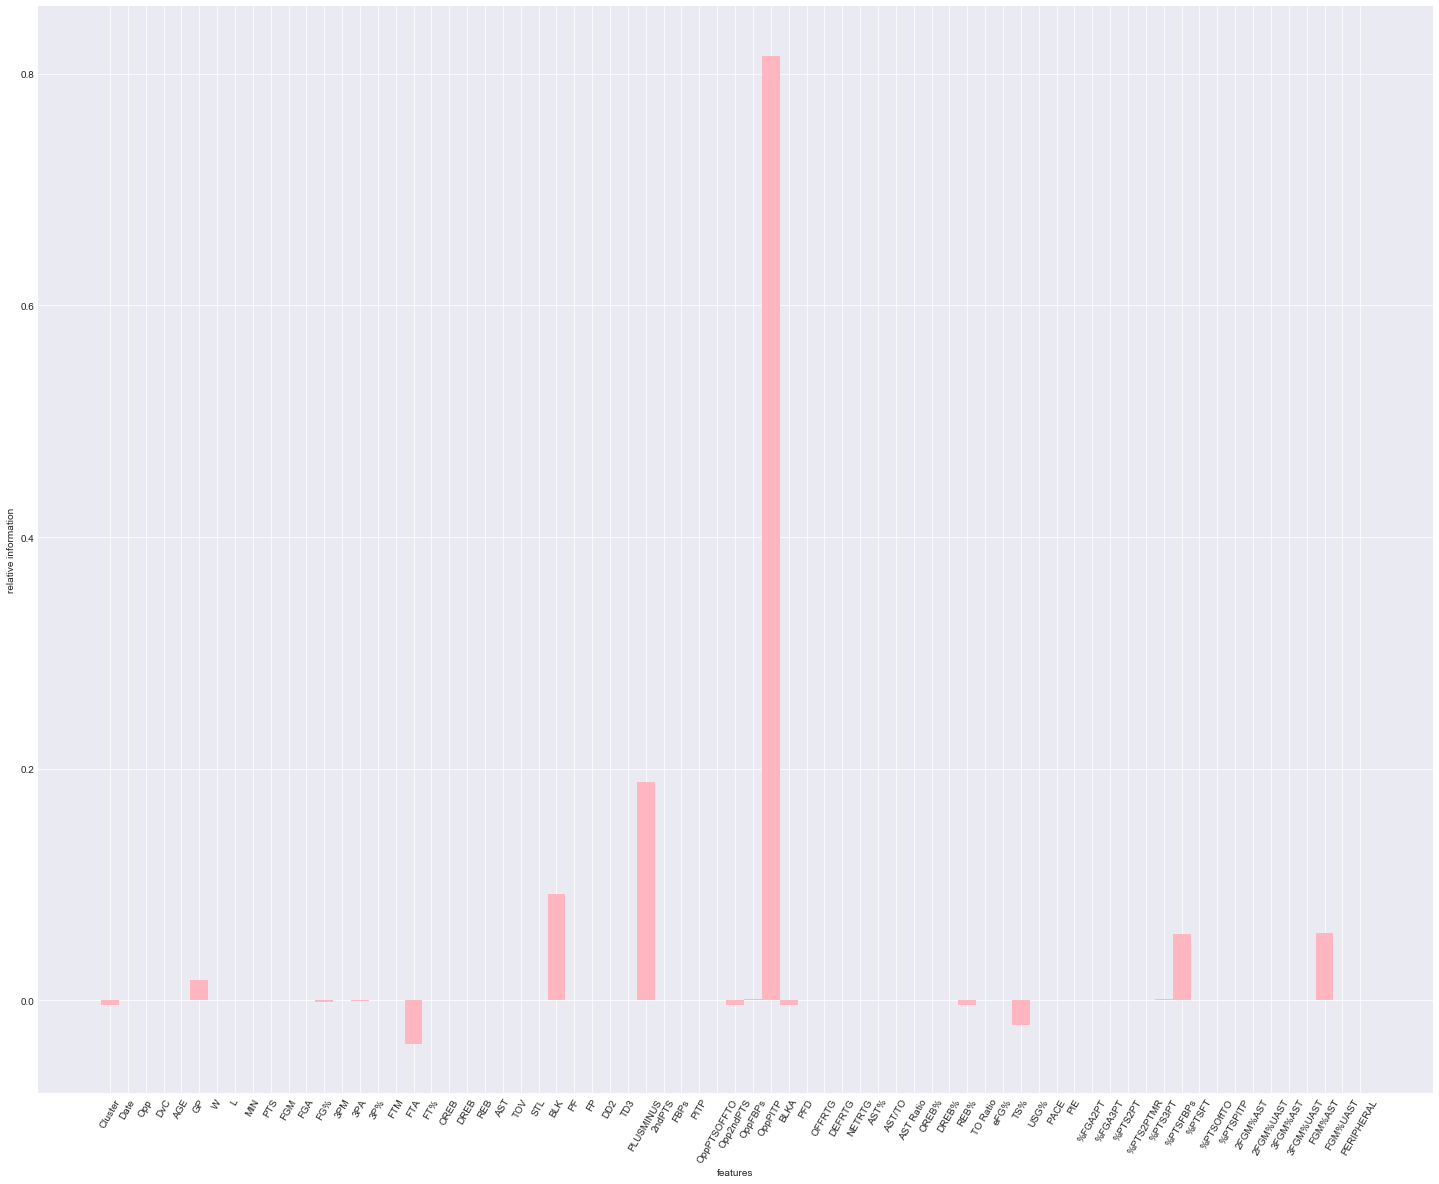

In [73]:
# Improve the visuals of previous plot
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(25,20))
plt.bar(enetcolumns, coef, width=1, color="lightpink",align='center')
plt.gca().set_xticklabels(range(len(enetcolumns)), rotation=60 )
plt.xticks(range(len(enetcolumns)), enetcolumns.values)
plt.ylabel("relative information")
plt.xlabel("features")
plt.show()

### Random Forest 

Next we will try to use random forest and aim to curtail problems such as overfitting and high variance to improve our feature selection and model's performance  

In [74]:
# Import the necessary packages
from sklearn.ensemble import RandomForestRegressor 

# Feature selection with a forest of 10 decision trees 
n_trees = 10
features = mergedf.drop(['FDP', 'PLAYER'], axis=1).columns
rf = RandomForestRegressor(n_trees)
rf.fit(X, y)
plt_x = np.linspace(0, len(features)-1, len(features))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), rf.feature_importances_), features),
             reverse=True))

Features sorted by their score:
[(0.52, 'FP'), (0.13, 'Date'), (0.11, 'DvC'), (0.08, 'Opp'), (0.0, 'eFG%'), (0.0, 'W'), (0.0, 'USG%'), (0.0, 'TS%'), (0.0, 'TO\xa0Ratio'), (0.0, 'TOV'), (0.0, 'TD3'), (0.0, 'STL'), (0.0, 'REB%'), (0.0, 'REB'), (0.0, 'PTS'), (0.0, 'PLUSMINUS'), (0.0, 'PITP'), (0.0, 'PIE'), (0.0, 'PFD'), (0.0, 'PF'), (0.0, 'PERIPHERAL'), (0.0, 'PACE'), (0.0, 'OppPTSOFFTO'), (0.0, 'OppPITP'), (0.0, 'OppFBPs'), (0.0, 'Opp2ndPTS'), (0.0, 'OREB%'), (0.0, 'OREB'), (0.0, 'OFFRTG'), (0.0, 'NETRTG'), (0.0, 'MIN'), (0.0, 'L'), (0.0, 'GP'), (0.0, 'FTM'), (0.0, 'FTA'), (0.0, 'FT%'), (0.0, 'FGM%UAST'), (0.0, 'FGM%AST'), (0.0, 'FGM'), (0.0, 'FGA'), (0.0, 'FG%'), (0.0, 'FBPs'), (0.0, 'DREB%'), (0.0, 'DREB'), (0.0, 'DEFRTG'), (0.0, 'DD2'), (0.0, 'Cluster'), (0.0, 'BLKA'), (0.0, 'BLK'), (0.0, 'AST\xa0Ratio'), (0.0, 'AST/TO'), (0.0, 'AST%'), (0.0, 'AST'), (0.0, 'AGE'), (0.0, '3PM'), (0.0, '3PA'), (0.0, '3P%'), (0.0, '3FGM%UAST'), (0.0, '3FGM%AST'), (0.0, '2ndPTS'), (0.0, '2FGM%UAST'), (0.0

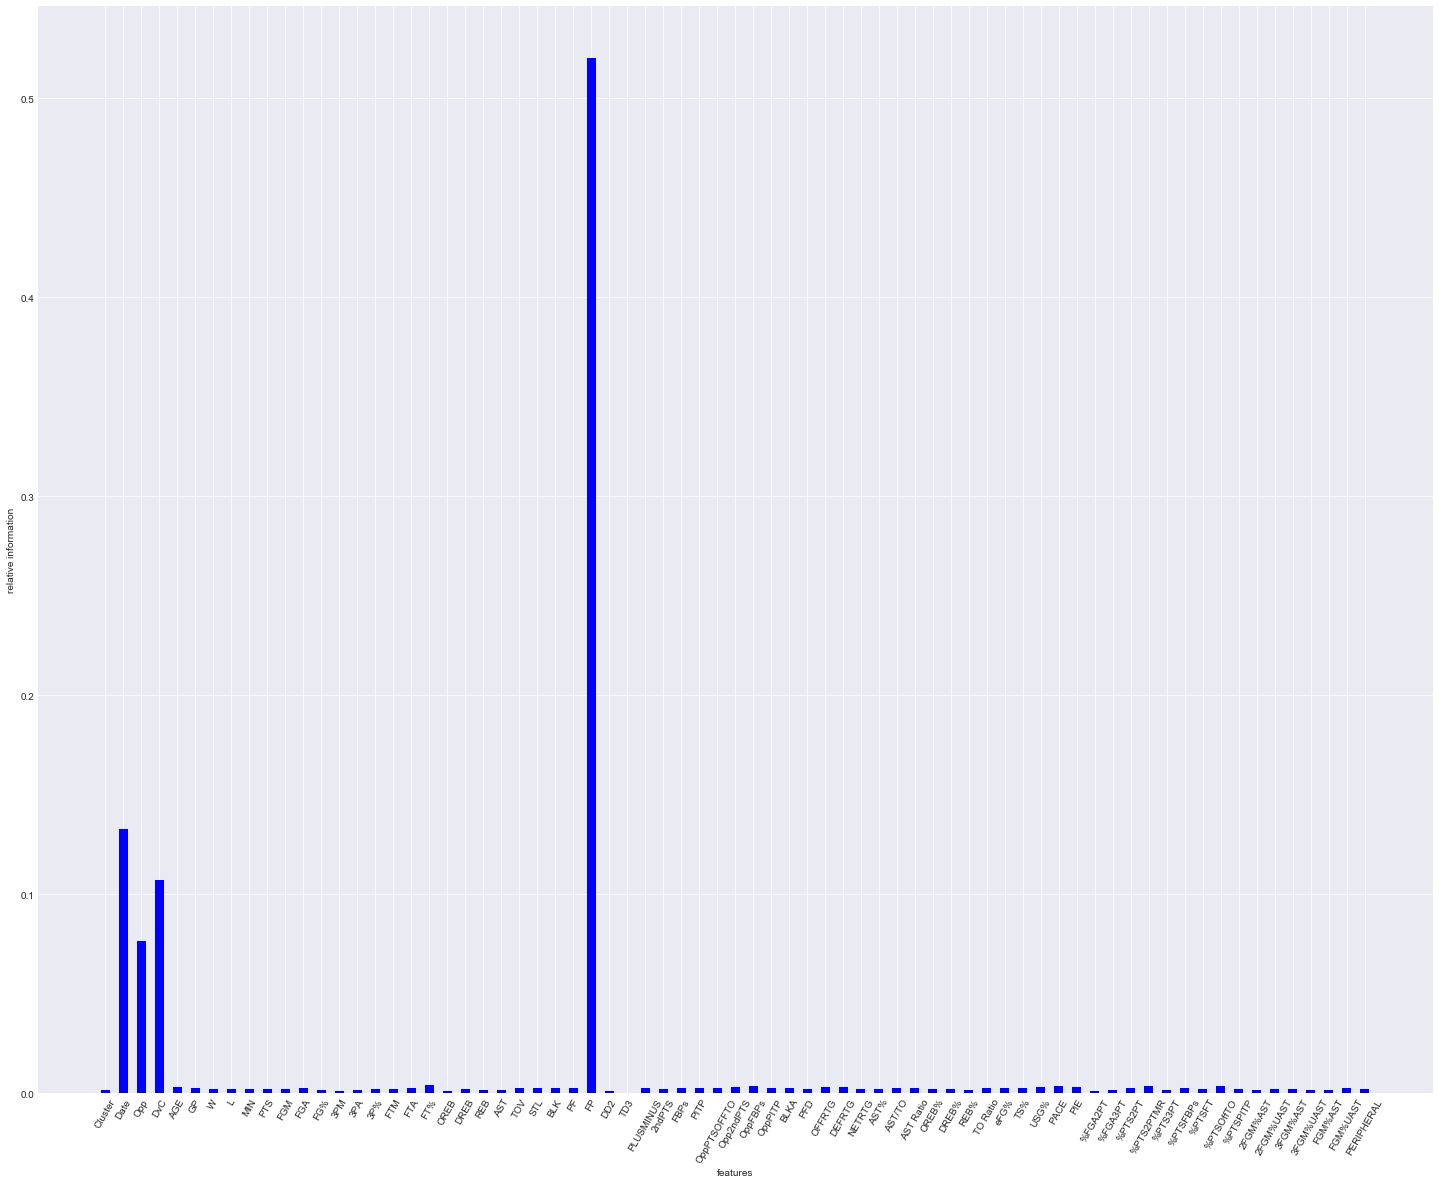

In [75]:
# Plot the feature importance 
plt.figure(figsize=(25,20))

plt.bar(plt_x, rf.feature_importances_, width=0.5, color="blue",align='center')
plt.gca().set_xticklabels(plt_x, rotation=60 )
plt.xticks(plt_x, features)
plt.ylabel("relative information")
plt.xlabel("features")
plt.show()

Features sorted by their score:
[(0.52, 'FP'), (0.13, 'Date'), (0.1, 'DvC'), (0.08, 'Opp'), (0.0, 'eFG%'), (0.0, 'W'), (0.0, 'USG%'), (0.0, 'TS%'), (0.0, 'TO\xa0Ratio'), (0.0, 'TOV'), (0.0, 'TD3'), (0.0, 'STL'), (0.0, 'REB%'), (0.0, 'REB'), (0.0, 'PTS'), (0.0, 'PLUSMINUS'), (0.0, 'PITP'), (0.0, 'PIE'), (0.0, 'PFD'), (0.0, 'PF'), (0.0, 'PERIPHERAL'), (0.0, 'PACE'), (0.0, 'OppPTSOFFTO'), (0.0, 'OppPITP'), (0.0, 'OppFBPs'), (0.0, 'Opp2ndPTS'), (0.0, 'OREB%'), (0.0, 'OREB'), (0.0, 'OFFRTG'), (0.0, 'NETRTG'), (0.0, 'MIN'), (0.0, 'L'), (0.0, 'GP'), (0.0, 'FTM'), (0.0, 'FTA'), (0.0, 'FT%'), (0.0, 'FGM%UAST'), (0.0, 'FGM%AST'), (0.0, 'FGM'), (0.0, 'FGA'), (0.0, 'FG%'), (0.0, 'FBPs'), (0.0, 'DREB%'), (0.0, 'DREB'), (0.0, 'DEFRTG'), (0.0, 'DD2'), (0.0, 'Cluster'), (0.0, 'BLKA'), (0.0, 'BLK'), (0.0, 'AST\xa0Ratio'), (0.0, 'AST/TO'), (0.0, 'AST%'), (0.0, 'AST'), (0.0, 'AGE'), (0.0, '3PM'), (0.0, '3PA'), (0.0, '3P%'), (0.0, '3FGM%UAST'), (0.0, '3FGM%AST'), (0.0, '2ndPTS'), (0.0, '2FGM%UAST'), (0.0,

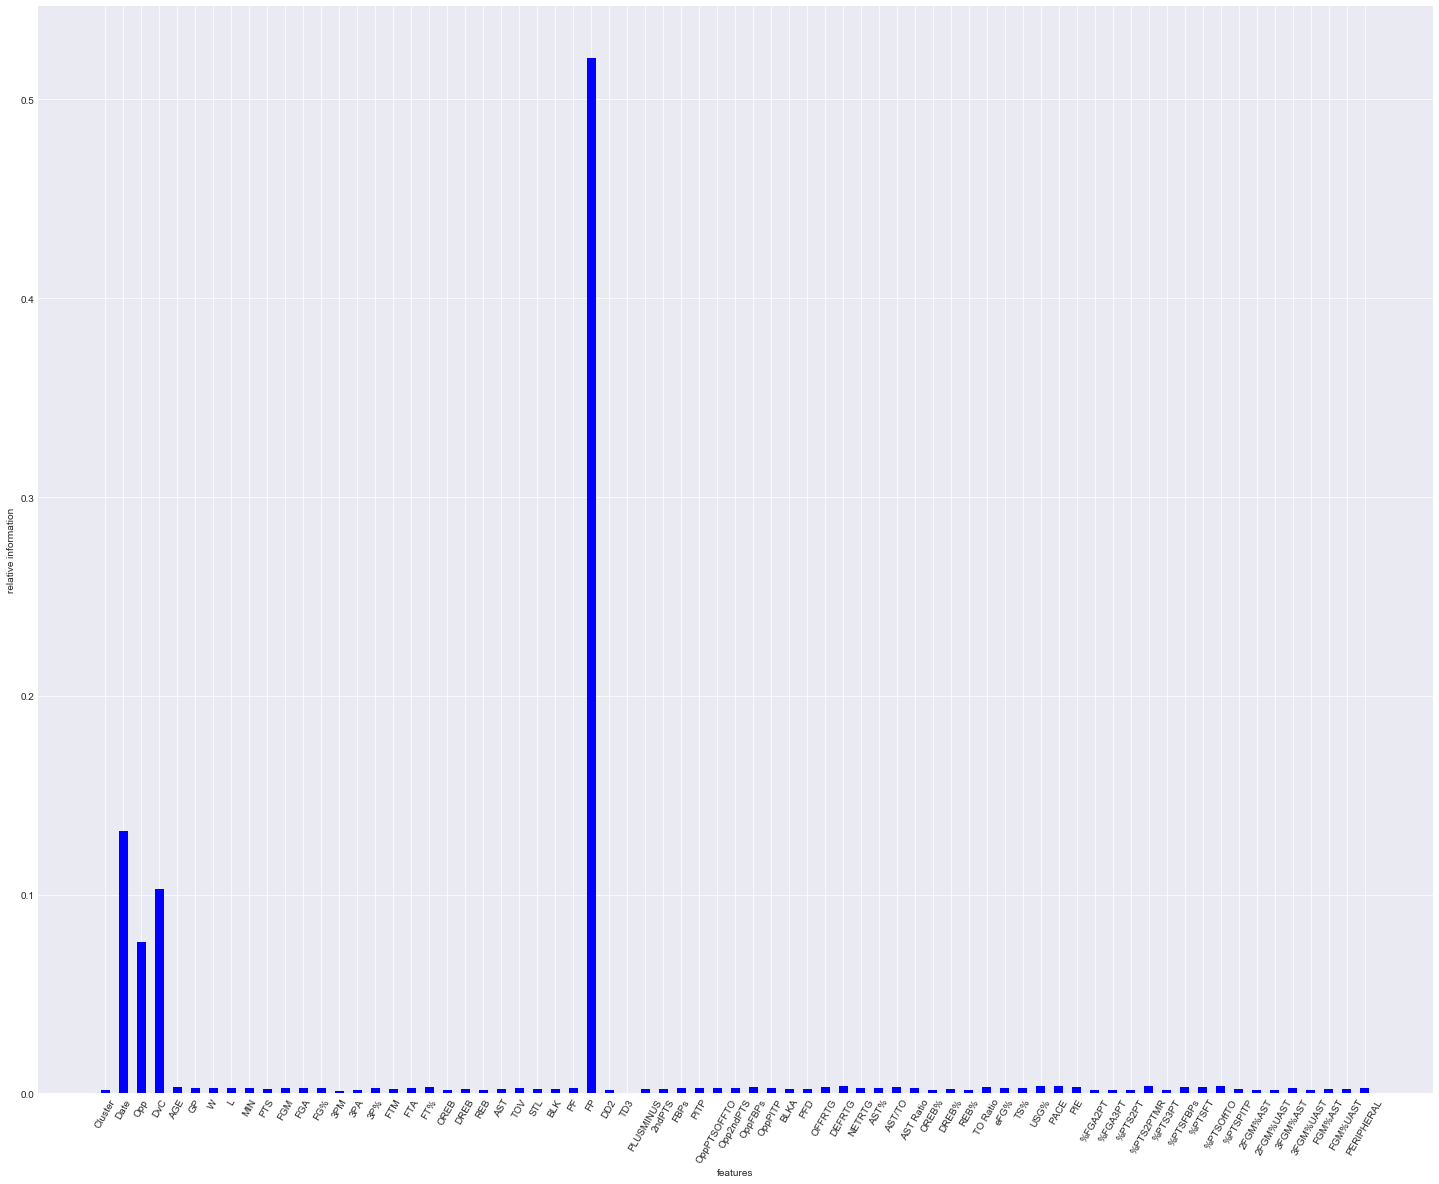

In [76]:
# Feature selection score and plot with a forest of 100 decision trees 

n_trees = 100
features = mergedf.drop(['FDP', 'PLAYER'], axis=1).columns
rf = RandomForestRegressor(n_trees)
rf.fit(X, y)
plt_x = np.linspace(0, len(features)-1, len(features))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), rf.feature_importances_), features),
             reverse=True))
plt.figure(figsize=(25,20))

plt.bar(plt_x, rf.feature_importances_, width=0.5, color="blue",align='center')
plt.gca().set_xticklabels(plt_x, rotation=60 )
plt.xticks(plt_x, features)
plt.ylabel("relative information")
plt.xlabel("features")
plt.show()

Features sorted by their score:
[(0.52, 'FP'), (0.13, 'Date'), (0.1, 'DvC'), (0.08, 'Opp'), (0.0, 'eFG%'), (0.0, 'W'), (0.0, 'USG%'), (0.0, 'TS%'), (0.0, 'TO\xa0Ratio'), (0.0, 'TOV'), (0.0, 'TD3'), (0.0, 'STL'), (0.0, 'REB%'), (0.0, 'REB'), (0.0, 'PTS'), (0.0, 'PLUSMINUS'), (0.0, 'PITP'), (0.0, 'PIE'), (0.0, 'PFD'), (0.0, 'PF'), (0.0, 'PERIPHERAL'), (0.0, 'PACE'), (0.0, 'OppPTSOFFTO'), (0.0, 'OppPITP'), (0.0, 'OppFBPs'), (0.0, 'Opp2ndPTS'), (0.0, 'OREB%'), (0.0, 'OREB'), (0.0, 'OFFRTG'), (0.0, 'NETRTG'), (0.0, 'MIN'), (0.0, 'L'), (0.0, 'GP'), (0.0, 'FTM'), (0.0, 'FTA'), (0.0, 'FT%'), (0.0, 'FGM%UAST'), (0.0, 'FGM%AST'), (0.0, 'FGM'), (0.0, 'FGA'), (0.0, 'FG%'), (0.0, 'FBPs'), (0.0, 'DREB%'), (0.0, 'DREB'), (0.0, 'DEFRTG'), (0.0, 'DD2'), (0.0, 'Cluster'), (0.0, 'BLKA'), (0.0, 'BLK'), (0.0, 'AST\xa0Ratio'), (0.0, 'AST/TO'), (0.0, 'AST%'), (0.0, 'AST'), (0.0, 'AGE'), (0.0, '3PM'), (0.0, '3PA'), (0.0, '3P%'), (0.0, '3FGM%UAST'), (0.0, '3FGM%AST'), (0.0, '2ndPTS'), (0.0, '2FGM%UAST'), (0.0,

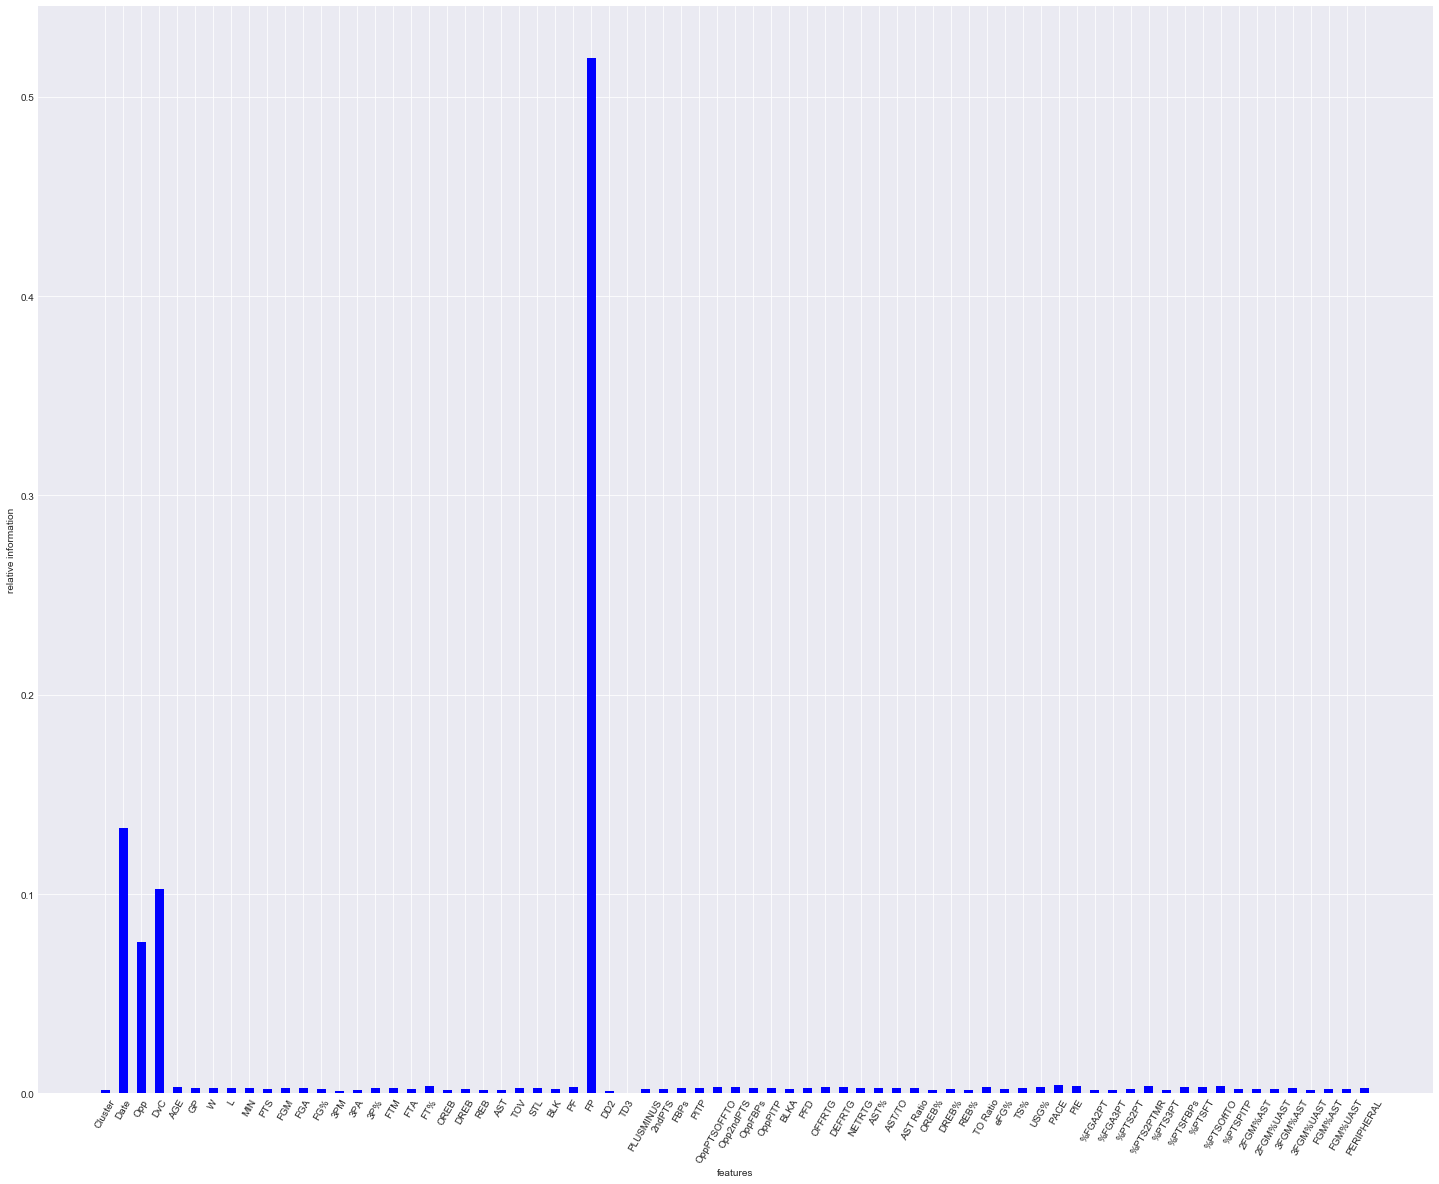

In [77]:
# Feature selection score and plot with a forest of 200 decision trees 
n_trees = 200
features = mergedf.drop(['FDP', 'PLAYER'], axis=1).columns
rf = RandomForestRegressor(n_trees)
rf.fit(X, y)
plt_x = np.linspace(0, len(features)-1, len(features))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), rf.feature_importances_), features),
             reverse=True))
plt.figure(figsize=(25,20))

plt.bar(plt_x, rf.feature_importances_, width=0.5, color="blue",align='center')
plt.gca().set_xticklabels(plt_x, rotation=60 )
plt.xticks(plt_x, features)
plt.ylabel("relative information")
plt.xlabel("features")
plt.show()

We see that the most important features when considering all variables are the player's season fantasy points, the Date and opponent of the game, and the defense vs cluser ratio

In [78]:
# When we remove these variables the next important features are second chance points, age, wins, and games played
n_trees = 100
features = mergedf.drop(['FDP', 'FP', 'Date', 'DvC', 'Opp', 'PLAYER'], axis=1).columns
rf = RandomForestRegressor(n_trees)
rf.fit(X, y)
plt_x = np.linspace(0, len(features)-1, len(features))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), rf.feature_importances_), features),
             reverse=True))                                            

Features sorted by their score:
[(0.52, '2ndPTS'), (0.13, 'AGE'), (0.1, 'W'), (0.08, 'GP'), (0.0, 'eFG%'), (0.0, 'USG%'), (0.0, 'TS%'), (0.0, 'TO\xa0Ratio'), (0.0, 'TOV'), (0.0, 'TD3'), (0.0, 'STL'), (0.0, 'REB%'), (0.0, 'REB'), (0.0, 'PTS'), (0.0, 'PLUSMINUS'), (0.0, 'PITP'), (0.0, 'PIE'), (0.0, 'PFD'), (0.0, 'PF'), (0.0, 'PERIPHERAL'), (0.0, 'PACE'), (0.0, 'OppPTSOFFTO'), (0.0, 'OppPITP'), (0.0, 'OppFBPs'), (0.0, 'Opp2ndPTS'), (0.0, 'OREB%'), (0.0, 'OREB'), (0.0, 'OFFRTG'), (0.0, 'NETRTG'), (0.0, 'MIN'), (0.0, 'L'), (0.0, 'FTM'), (0.0, 'FTA'), (0.0, 'FT%'), (0.0, 'FGM%UAST'), (0.0, 'FGM%AST'), (0.0, 'FGM'), (0.0, 'FGA'), (0.0, 'FG%'), (0.0, 'FBPs'), (0.0, 'DREB%'), (0.0, 'DREB'), (0.0, 'DEFRTG'), (0.0, 'DD2'), (0.0, 'Cluster'), (0.0, 'BLKA'), (0.0, 'BLK'), (0.0, 'AST\xa0Ratio'), (0.0, 'AST/TO'), (0.0, 'AST%'), (0.0, 'AST'), (0.0, '3PM'), (0.0, '3PA'), (0.0, '3P%'), (0.0, '3FGM%UAST'), (0.0, '3FGM%AST'), (0.0, '2FGM%UAST'), (0.0, '2FGM%AST'), (0.0, '%PTSPITP'), (0.0, '%PTSOffTO'), (0.

In [79]:
# The next relative important features are listed below
n_trees = 100
features = mergedf.drop(['FDP', 'FP', 'Date', 'DvC', 'Opp', 'PLAYER', '2ndPTS', 'AGE', 'W', 'GP', 
                         'Opp2ndPTS', 'L', 'PTS','MIN'], axis=1).columns
rf = RandomForestRegressor(n_trees)
rf.fit(X, y)
plt_x = np.linspace(0, len(features)-1, len(features))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), rf.feature_importances_), features),
             reverse=True))              

Features sorted by their score:
[(0.52, 'PFD'), (0.13, 'FGM'), (0.1, 'FG%'), (0.08, 'FGA'), (0.0, 'eFG%'), (0.0, 'USG%'), (0.0, 'TS%'), (0.0, 'TO\xa0Ratio'), (0.0, 'TOV'), (0.0, 'TD3'), (0.0, 'STL'), (0.0, 'REB%'), (0.0, 'REB'), (0.0, 'PLUSMINUS'), (0.0, 'PITP'), (0.0, 'PIE'), (0.0, 'PF'), (0.0, 'PERIPHERAL'), (0.0, 'PACE'), (0.0, 'OppPTSOFFTO'), (0.0, 'OppPITP'), (0.0, 'OppFBPs'), (0.0, 'OREB%'), (0.0, 'OREB'), (0.0, 'OFFRTG'), (0.0, 'NETRTG'), (0.0, 'FTM'), (0.0, 'FTA'), (0.0, 'FT%'), (0.0, 'FGM%UAST'), (0.0, 'FGM%AST'), (0.0, 'FBPs'), (0.0, 'DREB%'), (0.0, 'DREB'), (0.0, 'DEFRTG'), (0.0, 'DD2'), (0.0, 'Cluster'), (0.0, 'BLKA'), (0.0, 'BLK'), (0.0, 'AST\xa0Ratio'), (0.0, 'AST/TO'), (0.0, 'AST%'), (0.0, 'AST'), (0.0, '3PM'), (0.0, '3PA'), (0.0, '3P%'), (0.0, '3FGM%UAST'), (0.0, '3FGM%AST'), (0.0, '2FGM%UAST'), (0.0, '2FGM%AST'), (0.0, '%PTSPITP'), (0.0, '%PTSOffTO'), (0.0, '%PTSFT'), (0.0, '%PTSFBPs'), (0.0, '%PTS3PT'), (0.0, '%PTS2PTMR'), (0.0, '%PTS2PT'), (0.0, '%FGA3PT'), (0.0, '%F

In [80]:
# The next relative important features are listed below
n_trees = 100
features = mergedf.drop(['FDP', 'FP', 'Date', 'DvC', 'Opp', 'PLAYER', '2ndPTS', 'AGE', 'W', 'GP', 
                         'Opp2ndPTS', 'L', 'PTS','MIN', 'PFD', 'FGM','FG%','FGA'], axis=1).columns
rf = RandomForestRegressor(n_trees)
rf.fit(X, y)
plt_x = np.linspace(0, len(features)-1, len(features))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), rf.feature_importances_), features),
             reverse=True))
                              

Features sorted by their score:
[(0.52, 'AST%'), (0.13, '3PM'), (0.1, '3P%'), (0.08, '3PA'), (0.0, 'eFG%'), (0.0, 'USG%'), (0.0, 'TS%'), (0.0, 'TO\xa0Ratio'), (0.0, 'TOV'), (0.0, 'TD3'), (0.0, 'STL'), (0.0, 'REB%'), (0.0, 'REB'), (0.0, 'PLUSMINUS'), (0.0, 'PITP'), (0.0, 'PIE'), (0.0, 'PF'), (0.0, 'PERIPHERAL'), (0.0, 'PACE'), (0.0, 'OppPTSOFFTO'), (0.0, 'OppPITP'), (0.0, 'OppFBPs'), (0.0, 'OREB%'), (0.0, 'OREB'), (0.0, 'OFFRTG'), (0.0, 'NETRTG'), (0.0, 'FTM'), (0.0, 'FTA'), (0.0, 'FT%'), (0.0, 'FGM%UAST'), (0.0, 'FGM%AST'), (0.0, 'FBPs'), (0.0, 'DREB%'), (0.0, 'DREB'), (0.0, 'DEFRTG'), (0.0, 'DD2'), (0.0, 'Cluster'), (0.0, 'BLKA'), (0.0, 'BLK'), (0.0, 'AST\xa0Ratio'), (0.0, 'AST/TO'), (0.0, 'AST'), (0.0, '3FGM%UAST'), (0.0, '3FGM%AST'), (0.0, '2FGM%UAST'), (0.0, '2FGM%AST'), (0.0, '%PTSPITP'), (0.0, '%PTSOffTO'), (0.0, '%PTSFT'), (0.0, '%PTSFBPs'), (0.0, '%PTS3PT'), (0.0, '%PTS2PTMR'), (0.0, '%PTS2PT'), (0.0, '%FGA3PT'), (0.0, '%FGA2PT')]


In [81]:
# The next relative important features are listed below
n_trees = 100
features = mergedf.drop(['FDP', 'FP', 'Date', 'DvC', 'Opp', 'PLAYER', '2ndPTS', 'AGE', 'W', 'GP', 
                         'Opp2ndPTS', 'L', 'PTS','MIN', 'PFD', 'FGM','FG%','FGA','AST%','3PM',
                         '3P%', '3PA'], axis=1).columns
rf = RandomForestRegressor(n_trees)
rf.fit(X, y)
plt_x = np.linspace(0, len(features)-1, len(features))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), rf.feature_importances_), features),
             reverse=True))                                           

Features sorted by their score:
[(0.52, 'DREB%'), (0.13, 'FTM'), (0.1, 'FT%'), (0.08, 'FTA'), (0.0, 'eFG%'), (0.0, 'USG%'), (0.0, 'TS%'), (0.0, 'TO\xa0Ratio'), (0.0, 'TOV'), (0.0, 'TD3'), (0.0, 'STL'), (0.0, 'REB%'), (0.0, 'REB'), (0.0, 'PLUSMINUS'), (0.0, 'PITP'), (0.0, 'PIE'), (0.0, 'PF'), (0.0, 'PERIPHERAL'), (0.0, 'PACE'), (0.0, 'OppPTSOFFTO'), (0.0, 'OppPITP'), (0.0, 'OppFBPs'), (0.0, 'OREB%'), (0.0, 'OREB'), (0.0, 'OFFRTG'), (0.0, 'NETRTG'), (0.0, 'FGM%UAST'), (0.0, 'FGM%AST'), (0.0, 'FBPs'), (0.0, 'DREB'), (0.0, 'DEFRTG'), (0.0, 'DD2'), (0.0, 'Cluster'), (0.0, 'BLKA'), (0.0, 'BLK'), (0.0, 'AST\xa0Ratio'), (0.0, 'AST/TO'), (0.0, 'AST'), (0.0, '3FGM%UAST'), (0.0, '3FGM%AST'), (0.0, '2FGM%UAST'), (0.0, '2FGM%AST'), (0.0, '%PTSPITP'), (0.0, '%PTSOffTO'), (0.0, '%PTSFT'), (0.0, '%PTSFBPs'), (0.0, '%PTS3PT'), (0.0, '%PTS2PTMR'), (0.0, '%PTS2PT'), (0.0, '%FGA3PT'), (0.0, '%FGA2PT')]


In [82]:
# The next relative important features are listed below
n_trees = 100
features = mergedf.drop(['FDP', 'FP', 'Date', 'DvC', 'Opp', 'PLAYER', '2ndPTS', 'AGE', 'W', 'GP', 
                         'Opp2ndPTS', 'L', 'PTS','MIN', 'PFD', 'FGM','FG%','FGA','AST%','3PM',
                         '3P%', '3PA','DREB%', 'FTM', 'FT%', 'FTA'], axis=1).columns
rf = RandomForestRegressor(n_trees)
rf.fit(X, y)
plt_x = np.linspace(0, len(features)-1, len(features))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), rf.feature_importances_), features),
             reverse=True))

Features sorted by their score:
[(0.52, 'TS%'), (0.13, 'OREB'), (0.1, 'REB'), (0.08, 'DREB'), (0.0, 'eFG%'), (0.0, 'USG%'), (0.0, 'TO\xa0Ratio'), (0.0, 'TOV'), (0.0, 'TD3'), (0.0, 'STL'), (0.0, 'REB%'), (0.0, 'PLUSMINUS'), (0.0, 'PITP'), (0.0, 'PIE'), (0.0, 'PF'), (0.0, 'PERIPHERAL'), (0.0, 'PACE'), (0.0, 'OppPTSOFFTO'), (0.0, 'OppPITP'), (0.0, 'OppFBPs'), (0.0, 'OREB%'), (0.0, 'OFFRTG'), (0.0, 'NETRTG'), (0.0, 'FGM%UAST'), (0.0, 'FGM%AST'), (0.0, 'FBPs'), (0.0, 'DEFRTG'), (0.0, 'DD2'), (0.0, 'Cluster'), (0.0, 'BLKA'), (0.0, 'BLK'), (0.0, 'AST\xa0Ratio'), (0.0, 'AST/TO'), (0.0, 'AST'), (0.0, '3FGM%UAST'), (0.0, '3FGM%AST'), (0.0, '2FGM%UAST'), (0.0, '2FGM%AST'), (0.0, '%PTSPITP'), (0.0, '%PTSOffTO'), (0.0, '%PTSFT'), (0.0, '%PTSFBPs'), (0.0, '%PTS3PT'), (0.0, '%PTS2PTMR'), (0.0, '%PTS2PT'), (0.0, '%FGA3PT'), (0.0, '%FGA2PT')]


#### Random Forest Feature Selection Results

Below are the results of our random forest analysis with each feature and their relative importance with each subsequent group having less relative importance after removing the previous group. <br>
Group 1 ( 0.52, 'FP'), (0.13, 'Date'), (0.1, 'DvC'), (0.08, 'Opp')<br>
Group 2  (0.52, '2ndPTS'), (0.13, 'AGE'), (0.1, 'W'), (0.08, 'GP')<br>
Group 3  (0.52, 'Opp2ndPTS'), (0.13, 'L'), (0.1, 'PTS'), (0.08, 'MIN')  <br>
Group 4  (0.52, 'PFD'), (0.13, 'FGM'), (0.1, 'FG%'), (0.08, 'FGA')<br>
Group 5  (0.52, 'AST%'), (0.13, '3PM'), (0.1, '3P%'), (0.08, '3PA')<br>
Group 6  (0.52, 'DREB%'), (0.13, 'FTM'), (0.1, 'FT%'), (0.08, 'FTA') <br>
Group 7  (0.52, 'TS%'), (0.13, 'OREB'), (0.1, 'REB'), (0.08, 'DREB') <br>

These 28 features are mostly consistent with basketball strategies and conventional wisdom such as personal foul drawn should affect a player FP due to high PFD will lead to more fouls which leads to less minutes and less fantasy production. 

However, there is a couple of surprising omissions such as points in the paint, player impact estimate, usage rate, plus and minus, peripheral points, and net rating stats.

I suspect that these stats are important but they have small differences when adjusted for salary on a league-wide basis, and the 28 features above that edged out the omissions are very much related to the omitted stats. For instance, 

In [83]:
mergedf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Cluster,12978.0,3.278857e+00,2.117963,0.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00,7.000000e+00
Date,12978.0,2.017342e+07,3909.292814,2.017102e+07,2.017111e+07,2.017121e+07,2.018010e+07,2.018013e+07
Opp,12978.0,1.545223e+01,8.673048,1.000000e+00,8.000000e+00,1.500000e+01,2.300000e+01,3.000000e+01
FDP,12978.0,2.333911e+01,12.756131,5.100000e+00,1.350000e+01,2.110000e+01,3.060000e+01,9.780000e+01
DvC,12978.0,-8.032959e+00,6.078990,-2.459087e+01,-1.225153e+01,-7.934451e+00,-4.332444e+00,2.120311e+01
AGE,12978.0,2.663099e+01,4.212947,1.900000e+01,2.300000e+01,2.600000e+01,2.900000e+01,4.000000e+01
GP,12978.0,2.912167e+01,5.863522,6.000000e+00,2.700000e+01,3.100000e+01,3.300000e+01,3.700000e+01
W,12978.0,1.469102e+01,5.788594,0.000000e+00,1.000000e+01,1.450000e+01,1.900000e+01,2.700000e+01
L,12978.0,1.443065e+01,5.247956,1.000000e+00,1.000000e+01,1.500000e+01,1.800000e+01,2.500000e+01
MIN,12978.0,2.439794e+01,7.430663,5.500000e+00,1.830000e+01,2.450000e+01,3.090000e+01,3.790000e+01


### eXtreme Gradient Boosting 

We now attempt to build the strongest predictive model while accounting for computational efficiency, feasibility, and model accuracy using XGBoosting and the insights from all of our previous operations thus far 

In [84]:
# Import necessary packages
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation, metrics 
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import r2_score

/Users/kaizen/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/kaizen/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [85]:
X

array([[3.0000000e+00, 2.0180128e+07, 5.0000000e+00, ..., 4.5700000e+01,
        5.4300000e+01, 2.6100000e+01],
       [3.0000000e+00, 2.0180126e+07, 2.0000000e+00, ..., 4.5700000e+01,
        5.4300000e+01, 2.6100000e+01],
       [3.0000000e+00, 2.0180117e+07, 1.6000000e+01, ..., 4.5700000e+01,
        5.4300000e+01, 2.6100000e+01],
       ...,
       [4.0000000e+00, 2.0171027e+07, 2.2000000e+01, ..., 0.0000000e+00,
        1.0000000e+02, 3.9000000e+00],
       [3.0000000e+00, 2.0171107e+07, 3.0000000e+01, ..., 9.0000000e+01,
        1.0000000e+01, 1.9000000e+00],
       [3.0000000e+00, 2.0171020e+07, 2.6000000e+01, ..., 9.0000000e+01,
        1.0000000e+01, 1.9000000e+00]])

In [86]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 42)

In [87]:
# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}

In [88]:
# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=8) 
grid = RandomizedSearchCV(xgb, params)
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=8, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'min_child_weight': [4, 5], 'gamma': [0.3, 0.4, 0.5], 'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], 'max_depth': [2, 3, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=0)

In [89]:
# Print the r2 score
print(r2_score(y_test, grid.best_estimator_.predict(X_test))) 

0.5320868328117551


In [90]:
y_pred = grid.predict(X_test)
r2 = grid.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Square Error: ', mse)
print('R-Square: ', r2)

Mean Square Error:  77.79392660016717
R-Square:  0.5320868328117551


### Next we rescale our data and remove extraneous variables and run XGBRegression again to attempt to improve our r-square score from xgboosting of 0.5247556585940722

In [91]:
finaldf = mergedf
finaldf

,PLAYER,Cluster,Date,Opp,FDP,DvC,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PLUSMINUS,2ndPTS,FBPs,PITP,OppPTSOFFTO,Opp2ndPTS,OppFBPs,OppPITP,BLKA,PFD,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE,%FGA2PT,%FGA3PT,%PTS2PT,%PTS2PTMR,%PTS3PT,%PTSFBPs,%PTSFT,%PTSOffTO,%PTSPITP,2FGM%AST,2FGM%UAST,3FGM%AST,3FGM%UAST,FGM%AST,FGM%UAST,PERIPHERAL
0,Giannis Antetokounmpo,3,20180128,5,52.8,-9.784139,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
1,Giannis Antetokounmpo,3,20180126,2,78.1,-12.757394,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
2,Giannis Antetokounmpo,3,20180117,16,54.0,-12.830732,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
3,Giannis Antetokounmpo,3,20180115,30,63.0,1.462796,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
4,Giannis Antetokounmpo,3,20180114,16,31.7,-12.830732,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
5,Giannis Antetokounmpo,3,20180112,10,37.4,-5.194044,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
6,Giannis Antetokounmpo,3,20180110,22,36.9,-10.579584,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
7,Giannis Antetokounmpo,3,20180108,12,34.9,-11.325054,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
8,Giannis Antetokounmpo,3,20180106,30,64.9,1.462796,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
9,Giannis Antetokounmpo,3,20180105,28,41.5,-21.375800,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1


In [92]:
# We drop the date column since it doesn't reflect the pricing fluctuations of salaries on FD
finaldf = finaldf.drop(['Date'], axis=1)
finaldf.head()

,PLAYER,Cluster,Opp,FDP,DvC,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PLUSMINUS,2ndPTS,FBPs,PITP,OppPTSOFFTO,Opp2ndPTS,OppFBPs,OppPITP,BLKA,PFD,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE,%FGA2PT,%FGA3PT,%PTS2PT,%PTS2PTMR,%PTS3PT,%PTSFBPs,%PTSFT,%PTSOffTO,%PTSPITP,2FGM%AST,2FGM%UAST,3FGM%AST,3FGM%UAST,FGM%AST,FGM%UAST,PERIPHERAL
0,Giannis Antetokounmpo,3,5,52.8,-9.784139,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
1,Giannis Antetokounmpo,3,2,78.1,-12.757394,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
2,Giannis Antetokounmpo,3,16,54.0,-12.830732,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
3,Giannis Antetokounmpo,3,30,63.0,1.462796,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
4,Giannis Antetokounmpo,3,16,31.7,-12.830732,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1


#### We also convert the Opp column back to their categorical features of team names and use OneHotEnconder() instead of simple integer encoding that is more suited for ordinal values to aim to improve our model 

In [93]:
# Create lists and dictionary to return team number designations to their abbreviations 
teamnumbers = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
nbateams = ["atl", "bkn", "bos", "cha", "chi", "cle", "dal", "den", "det", "gsw", "hou", "ind", "lac", "lal",
            "mem", "mia", "mil", "min", "nor", "nyk", "okc", "orl", "phi", "pho", "por", "sac", "sas", "tor",
            "uta", "was", ]
opp_dict = dict(zip(teamnumbers, nbateams))
print(opp_dict)

{1: 'atl', 2: 'bkn', 3: 'bos', 4: 'cha', 5: 'chi', 6: 'cle', 7: 'dal', 8: 'den', 9: 'det', 10: 'gsw', 11: 'hou', 12: 'ind', 13: 'lac', 14: 'lal', 15: 'mem', 16: 'mia', 17: 'mil', 18: 'min', 19: 'nor', 20: 'nyk', 21: 'okc', 22: 'orl', 23: 'phi', 24: 'pho', 25: 'por', 26: 'sac', 27: 'sas', 28: 'tor', 29: 'uta', 30: 'was'}


In [94]:
# Ensure the Opp column now has each correct team abbreviation for each opponent
finaldf = finaldf.replace({'Opp':opp_dict})
finaldf.head()

,PLAYER,Cluster,Opp,FDP,DvC,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PLUSMINUS,2ndPTS,FBPs,PITP,OppPTSOFFTO,Opp2ndPTS,OppFBPs,OppPITP,BLKA,PFD,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE,%FGA2PT,%FGA3PT,%PTS2PT,%PTS2PTMR,%PTS3PT,%PTSFBPs,%PTSFT,%PTSOffTO,%PTSPITP,2FGM%AST,2FGM%UAST,3FGM%AST,3FGM%UAST,FGM%AST,FGM%UAST,PERIPHERAL
0,Giannis Antetokounmpo,3,chi,52.8,-9.784139,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
1,Giannis Antetokounmpo,3,bkn,78.1,-12.757394,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
2,Giannis Antetokounmpo,3,mia,54.0,-12.830732,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
3,Giannis Antetokounmpo,3,was,63.0,1.462796,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
4,Giannis Antetokounmpo,3,mia,31.7,-12.830732,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1


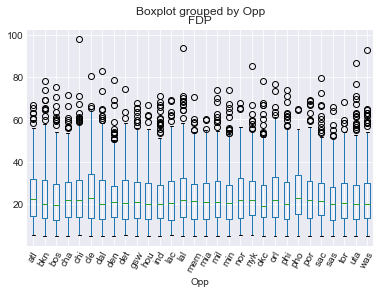

In [95]:
# EDA on Opp column
finaldf.boxplot('FDP', 'Opp', rot=60)

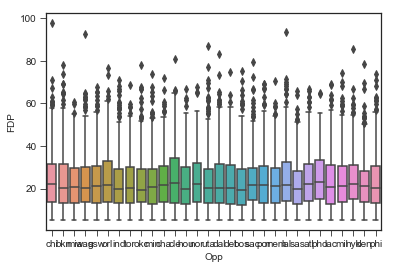

In [96]:
fdp = finaldf['FDP']
opp = finaldf['Opp']
sns.set_style('ticks')
sns.boxplot(x=opp, y=fdp)

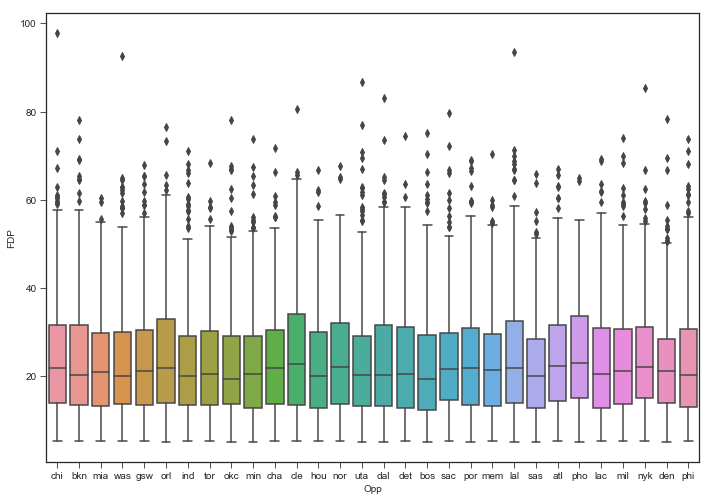

In [97]:
# Expand our previous plot for better interpretability
fdp = finaldf['FDP']
opp = finaldf['Opp']
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(x=opp, y=fdp)
plt.show()

### We can see that the worst-defending teams this season give up the highest fantasy points in the boxplot above

### Therefore, since we know Opponents carry explanatory power, we then create a OneHotEncoder for the Opponents column to give the machine learning operation more expressive power to learn a probability-like number for each possible value of fantasy points 

In [98]:
finaldf.head()

,PLAYER,Cluster,Opp,FDP,DvC,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PLUSMINUS,2ndPTS,FBPs,PITP,OppPTSOFFTO,Opp2ndPTS,OppFBPs,OppPITP,BLKA,PFD,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE,%FGA2PT,%FGA3PT,%PTS2PT,%PTS2PTMR,%PTS3PT,%PTSFBPs,%PTSFT,%PTSOffTO,%PTSPITP,2FGM%AST,2FGM%UAST,3FGM%AST,3FGM%UAST,FGM%AST,FGM%UAST,PERIPHERAL
0,Giannis Antetokounmpo,3,chi,52.8,-9.784139,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
1,Giannis Antetokounmpo,3,bkn,78.1,-12.757394,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
2,Giannis Antetokounmpo,3,mia,54.0,-12.830732,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
3,Giannis Antetokounmpo,3,was,63.0,1.462796,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1
4,Giannis Antetokounmpo,3,mia,31.7,-12.830732,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1


In [99]:
# Get one hot encoding labels for the opponents column 
one_hot = pd.get_dummies(finaldf['Opp'])

In [100]:
one_hot

,atl,bkn,bos,cha,chi,cle,dal,den,det,gsw,hou,ind,lac,lal,mem,mia,mil,min,nor,nyk,okc,orl,phi,pho,por,sac,sas,tor,uta,was
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [101]:
# Add our new one hot encoded data to original dataframe for more expressive machine learning
finaldf = finaldf.join(one_hot)

# Verify that the encoding is consistent 
# For instance, row 3 and 5 should have same onehotencoding data with Miami as the opponent
finaldf.head()

,PLAYER,Cluster,Opp,FDP,DvC,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PLUSMINUS,2ndPTS,FBPs,PITP,OppPTSOFFTO,Opp2ndPTS,OppFBPs,OppPITP,BLKA,PFD,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE,%FGA2PT,%FGA3PT,%PTS2PT,%PTS2PTMR,%PTS3PT,%PTSFBPs,%PTSFT,%PTSOffTO,%PTSPITP,2FGM%AST,2FGM%UAST,3FGM%AST,3FGM%UAST,FGM%AST,FGM%UAST,PERIPHERAL,atl,bkn,bos,cha,chi,cle,dal,den,det,gsw,hou,ind,lac,lal,mem,mia,mil,min,nor,nyk,okc,orl,phi,pho,por,sac,sas,tor,uta,was
0,Giannis Antetokounmpo,3,chi,52.8,-9.784139,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Giannis Antetokounmpo,3,bkn,78.1,-12.757394,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Giannis Antetokounmpo,3,mia,54.0,-12.830732,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Giannis Antetokounmpo,3,was,63.0,1.462796,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Giannis Antetokounmpo,3,mia,31.7,-12.830732,23,30,16,14,37.9,29.5,10.8,19.8,54.5,0.5,1.8,27.3,7.4,9.6,77.7,2.1,8.2,10.3,4.6,2.8,1.8,1.4,3.3,55.6,15,0,3.3,3.2,5.1,17.9,10.7,9.6,4.9,33.0,0.7,7.3,110.0,105.0,5.0,22.3,1.64,14.6,6.7,25.0,15.9,8.9,55.7,61.4,32.2,98.21,20.2,90.8,9.2,69.8,9.3,5.1,17.4,25.2,17.2,60.5,43.4,56.6,93.3,6.7,45.7,54.3,26.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Next we will scale our data before running xgboost again since our features are on dissimilar scales; for instance, some are stats with percentages while others are not

In [102]:
# Turn our columns into our features array 
X2 = finaldf.drop(['FDP', 'PLAYER', 'Opp'], axis=1).values
X2.shape

(12978, 99)

In [103]:
X2

array([[  3.        ,  -9.7841389 ,  23.        , ...,   0.        ,
          0.        ,   0.        ],
       [  3.        , -12.75739441,  23.        , ...,   0.        ,
          0.        ,   0.        ],
       [  3.        , -12.83073192,  23.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.        ,  -0.84162758,  23.        , ...,   0.        ,
          0.        ,   0.        ],
       [  3.        ,   1.46279559,  24.        , ...,   0.        ,
          0.        ,   1.        ],
       [  3.        ,  -6.10225142,  24.        , ...,   0.        ,
          0.        ,   0.        ]])

In [104]:
# Turn FDP column into our Fanduel Fantasy Points target array 
y2 = finaldf['FDP'].values
y2

array([52.8, 78.1, 54. , ...,  7.6,  9.7, 17.9])

In [105]:
y2.shape

(12978,)

In [106]:
# We first start with the popular standard scaler method
# that removes the means and scales our features data to unit variance 
from sklearn import preprocessing
Xscale = preprocessing.StandardScaler().fit_transform(X2)

In [107]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(Xscale, y2, test_size= 0.25, random_state= 42)

In [108]:
# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}


# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=8) 
grid = RandomizedSearchCV(xgb, params)
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=8, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'min_child_weight': [4, 5], 'gamma': [0.3, 0.4, 0.5], 'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], 'max_depth': [2, 3, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=0)

In [109]:
# Print the r2 score
print(r2_score(y_test, grid.best_estimator_.predict(X_test)))

0.5308237789287945


In [110]:
y_pred = grid.predict(X_test)
r2 = grid.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Square Error with Standard Scaler: ', mse)
print('R-Square with Standard Scaler: ', r2)

Mean Square Error with Standard Scaler:  78.00391838486846
R-Square with Standard Scaler:  0.5308237789287945


In [111]:
# We then rescales our data using MinMaxScaler such that all feature values are 
# in the range [0,1] to see if our R-Square is improved
# As StandardScaler, MinMaxScaler is very sensitive to the presence of outliers.

Xminmax = preprocessing.MinMaxScaler().fit_transform(X2)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(Xminmax, y2, test_size= 0.25, random_state= 42)

# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}


# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=8) 
grid = RandomizedSearchCV(xgb, params)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
r2 = grid.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Square Error with MinMaxScaler: ', mse)
print('R-Square with MinMaxScaler: ', r2)

Mean Square Error with MinMaxScaler:  78.01188331026817
R-Square with MinMaxScaler:  0.5307758716739086


In [112]:
# We also ran our model with using MaxAbsScaler that differ from StandardScaler() 
# and MinMaxScaler such that the absolute values are mapped in the range [0,1]
# MaxAbsScaler is also not as sensitve to the presennce of outliers like the previous two

Xmaxabs = preprocessing.MaxAbsScaler().fit_transform(X2)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(Xmaxabs, y2, test_size= 0.25, random_state= 42)

# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}


# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=8) 
grid = RandomizedSearchCV(xgb, params)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
r2 = grid.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Square Error with MaxAbsScaler: ', mse)
print('R-Square with MaxAbsScaler: ', r2)


Mean Square Error with MaxAbsScaler:  78.02357242197428
R-Square with MaxAbsScaler:  0.5307055642666463


In [113]:
# We also utilize RobustScaler(), which unlike previous scalers, implements percentiles 
# to reduce influences of very large and marginal outliers 
# this results in a range of transformed feature values larger than previous scalers and
# more importantly, are more approximately similar 

Xrobust = preprocessing.RobustScaler().fit_transform(X2)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(Xrobust, y2, test_size= 0.25, random_state= 42)

# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}


# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=8) 
grid = RandomizedSearchCV(xgb, params)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
r2 = grid.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Square Error with RobustScaler: ', mse)
print('R-Square with RobustScaler: ', r2)

Mean Square Error with RobustScaler:  78.02357242197428
R-Square with RobustScaler:  0.5307055642666463


In [114]:
# Additionally, we run QuantileTransformer so that the probability density function of each
# feature will be mapped to a uniform distribution to see if our resulting R-square will change

Xqt = preprocessing.QuantileTransformer().fit_transform(X2)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(Xqt, y2, test_size= 0.25, random_state= 42)

# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}


# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=8) 
grid = RandomizedSearchCV(xgb, params)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
r2 = grid.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Square Error with QuantileTransformer: ', mse)
print('R-Square with QuantileTransformer: ', r2)

Mean Square Error with QuantileTransformer:  78.1286181323589
R-Square with QuantileTransformer:  0.530073737680771


### We observed that the different scaling methods yield similar performance of our model

Unscaled <br>
Mean Square Error:  78.0125515160631 <br>
R-Square:  0.5274040697672309 <br>

Mean Square Error with Standard Scaler:  78.45360206489102 <br>
R-Square with Standard Scaler:  0.5247322087608634 <br>

Mean Square Error with MinMaxScaler:  78.29224403701797<br>
R-Square with MinMaxScaler:  0.5257097071992716<br>

Mean Square Error with MaxAbsScaler:  78.4817558902674<br>
R-Square with MaxAbsScaler:  0.5245616543688484<br>

Mean Square Error with RobustScaler:  78.50555589540772<br>
R-Square with RobustScaler:  0.5244174751906232<br>

Mean Square Error with QuantileTransformer:  78.57735919629974<br>
R-Square with QuantileTransformer:  0.5239824945737943<br>

### Conclusion

In [115]:
# We now put everything together to compute our model's coefficients
# using the importance of each feature which will help us with calculating
# a projection of fantasy points for each player using his stats

xgb_coef = xgb.fit(X2, y2).feature_importances_
xgb_coef

array([0.01015965, 0.19303338, 0.03193033, 0.00580552, 0.        ,
       0.00580552, 0.00580552, 0.00435414, 0.00870827, 0.01015965,
       0.00870827, 0.00870827, 0.00580552, 0.00580552, 0.00145138,
       0.00870827, 0.00435414, 0.        , 0.00290276, 0.        ,
       0.00435414, 0.01015965, 0.01015965, 0.00580552, 0.00725689,
       0.17561683, 0.00725689, 0.        , 0.00145138, 0.01015965,
       0.00725689, 0.00870827, 0.00290276, 0.00435414, 0.00725689,
       0.00145138, 0.00870827, 0.00435414, 0.01015965, 0.01161103,
       0.00435414, 0.00580552, 0.01451379, 0.00290276, 0.00290276,
       0.00725689, 0.00435414, 0.02467344, 0.00435414, 0.00290276,
       0.01161103, 0.0203193 , 0.01741655, 0.00435414, 0.        ,
       0.00870827, 0.00580552, 0.        , 0.01741655, 0.00290276,
       0.00725689, 0.01015965, 0.00870827, 0.        , 0.00145138,
       0.        , 0.00580552, 0.        , 0.01451379, 0.00290276,
       0.00870827, 0.00435414, 0.00145138, 0.00435414, 0.02322

In [116]:
xgb_coef.shape

(99,)

In [117]:
xgb_cols = finaldf.drop(['FDP', 'PLAYER', 'Opp'], axis=1).columns
xgb_cols

Index(['Cluster', 'DvC', 'AGE', 'GP', 'W', 'L', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', 'TD3', 'PLUSMINUS', '2ndPTS', 'FBPs', 'PITP', 'OppPTSOFFTO', 'Opp2ndPTS', 'OppFBPs', 'OppPITP', 'BLKA', 'PFD', 'OFFRTG', 'DEFRTG', 'NETRTG', 'AST%', 'AST/TO', 'AST Ratio', 'OREB%', 'DREB%', 'REB%', 'TO Ratio', 'eFG%', 'TS%', 'USG%', 'PACE', 'PIE', '%FGA2PT', '%FGA3PT', '%PTS2PT', '%PTS2PTMR', '%PTS3PT', '%PTSFBPs', '%PTSFT', '%PTSOffTO', '%PTSPITP', '2FGM%AST', '2FGM%UAST', '3FGM%AST', '3FGM%UAST', 'FGM%AST', 'FGM%UAST', 'PERIPHERAL', 'atl', 'bkn', 'bos', 'cha', 'chi', 'cle', 'dal', 'den', 'det', 'gsw', 'hou', 'ind', 'lac', 'lal', 'mem', 'mia', 'mil', 'min', 'nor', 'nyk', 'okc', 'orl', 'phi', 'pho', 'por', 'sac', 'sas', 'tor', 'uta', 'was'], dtype='object')

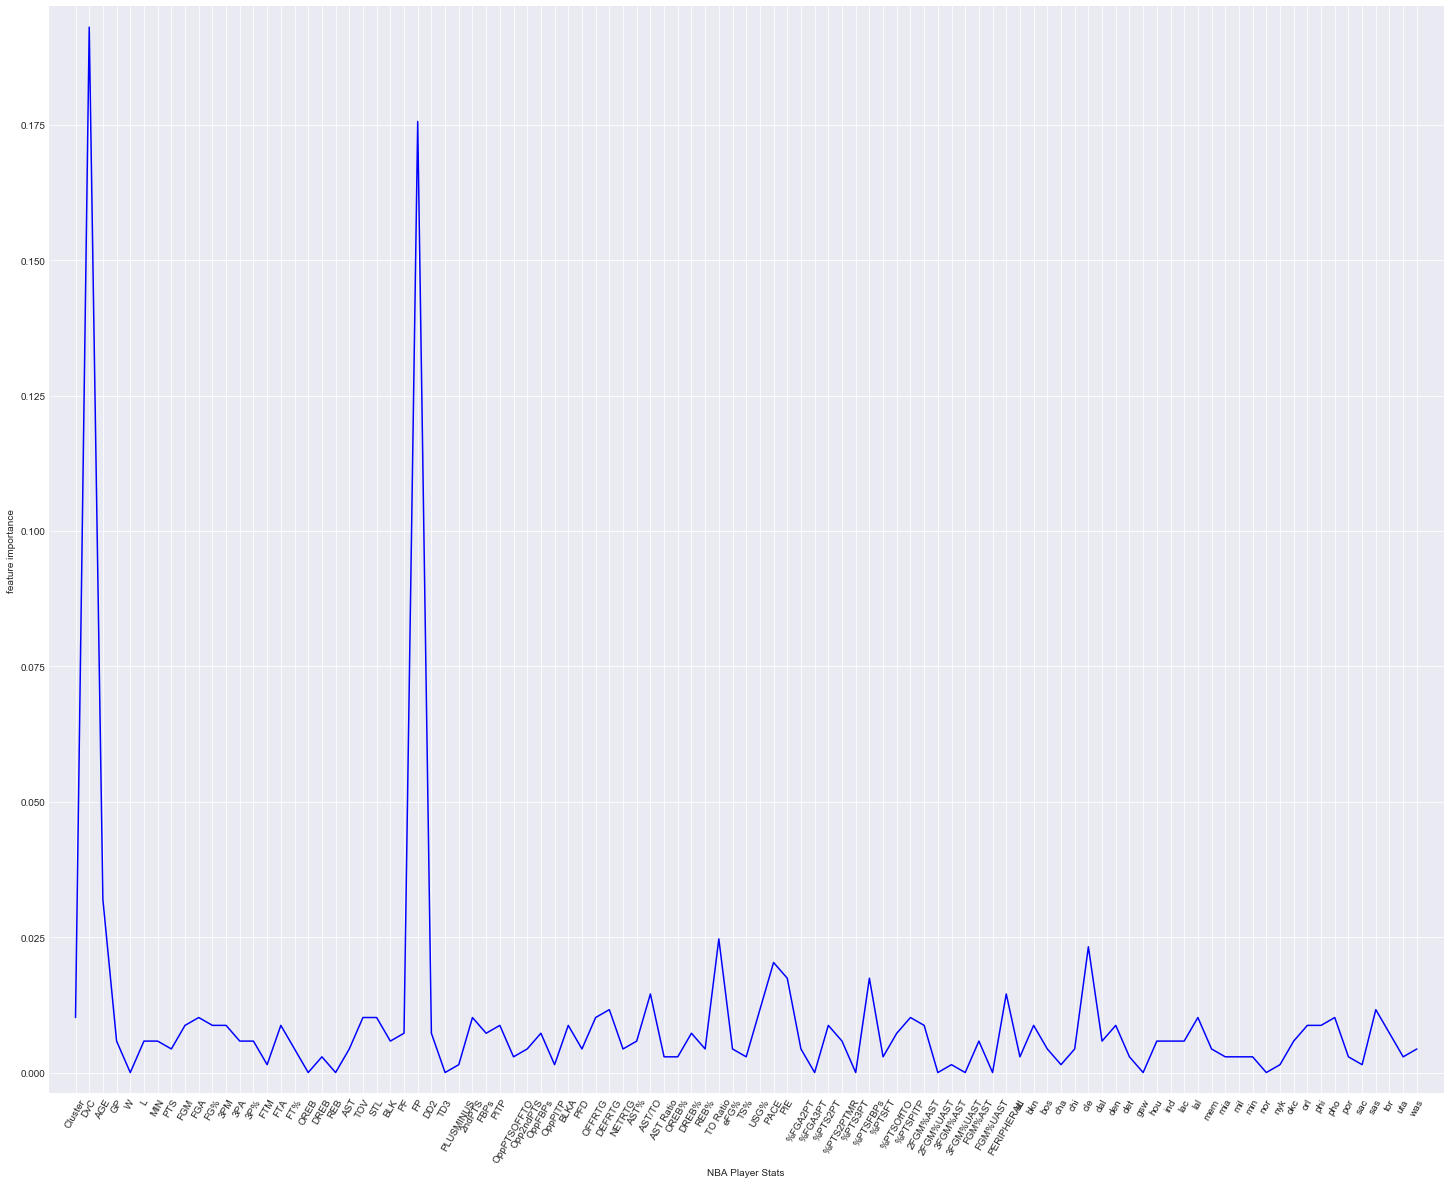

In [118]:
# Visualization of the feature importances
sns.set_style("darkgrid")
plt.figure(figsize=(25,20))
plt.plot(range(len(xgb_cols)), xgb_coef, color='blue')
plt.xticks(range(len(xgb_cols)), xgb_cols.values, rotation=60)
plt.margins(0.02)
plt.ylabel("feature importance")
plt.xlabel("NBA Player Stats")
plt.show()

In [119]:
xgb_cols

Index(['Cluster', 'DvC', 'AGE', 'GP', 'W', 'L', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', 'TD3', 'PLUSMINUS', '2ndPTS', 'FBPs', 'PITP', 'OppPTSOFFTO', 'Opp2ndPTS', 'OppFBPs', 'OppPITP', 'BLKA', 'PFD', 'OFFRTG', 'DEFRTG', 'NETRTG', 'AST%', 'AST/TO', 'AST Ratio', 'OREB%', 'DREB%', 'REB%', 'TO Ratio', 'eFG%', 'TS%', 'USG%', 'PACE', 'PIE', '%FGA2PT', '%FGA3PT', '%PTS2PT', '%PTS2PTMR', '%PTS3PT', '%PTSFBPs', '%PTSFT', '%PTSOffTO', '%PTSPITP', '2FGM%AST', '2FGM%UAST', '3FGM%AST', '3FGM%UAST', 'FGM%AST', 'FGM%UAST', 'PERIPHERAL', 'atl', 'bkn', 'bos', 'cha', 'chi', 'cle', 'dal', 'den', 'det', 'gsw', 'hou', 'ind', 'lac', 'lal', 'mem', 'mia', 'mil', 'min', 'nor', 'nyk', 'okc', 'orl', 'phi', 'pho', 'por', 'sac', 'sas', 'tor', 'uta', 'was'], dtype='object')

In [120]:
# Create a DataFrame that shows the importance of each feature
capstone_df = pd.DataFrame(index=xgb_cols)
capstone_df['Feature_Importance'] = xgb_coef

In [121]:
capstone_df

,Feature_Importance
Cluster,0.010160
DvC,0.193033
AGE,0.031930
GP,0.005806
W,0.000000
L,0.005806
MIN,0.005806
PTS,0.004354
FGM,0.008708
FGA,0.010160


In [122]:
capstone_df.transpose()

,Cluster,DvC,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PLUSMINUS,2ndPTS,FBPs,PITP,OppPTSOFFTO,Opp2ndPTS,OppFBPs,OppPITP,BLKA,PFD,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE,%FGA2PT,%FGA3PT,%PTS2PT,%PTS2PTMR,%PTS3PT,%PTSFBPs,%PTSFT,%PTSOffTO,%PTSPITP,2FGM%AST,2FGM%UAST,3FGM%AST,3FGM%UAST,FGM%AST,FGM%UAST,PERIPHERAL,atl,bkn,bos,cha,chi,cle,dal,den,det,gsw,hou,ind,lac,lal,mem,mia,mil,min,nor,nyk,okc,orl,phi,pho,por,sac,sas,tor,uta,was
Feature_Importance,0.01016,0.193033,0.03193,0.005806,0.0,0.005806,0.005806,0.004354,0.008708,0.01016,0.008708,0.008708,0.005806,0.005806,0.001451,0.008708,0.004354,0.0,0.002903,0.0,0.004354,0.01016,0.01016,0.005806,0.007257,0.175617,0.007257,0.0,0.001451,0.01016,0.007257,0.008708,0.002903,0.004354,0.007257,0.001451,0.008708,0.004354,0.01016,0.011611,0.004354,0.005806,0.014514,0.002903,0.002903,0.007257,0.004354,0.024673,0.004354,0.002903,0.011611,0.020319,0.017417,0.004354,0.0,0.008708,0.005806,0.0,0.017417,0.002903,0.007257,0.01016,0.008708,0.0,0.001451,0.0,0.005806,0.0,0.014514,0.002903,0.008708,0.004354,0.001451,0.004354,0.023222,0.005806,0.008708,0.002903,0.0,0.005806,0.005806,0.005806,0.01016,0.004354,0.002903,0.002903,0.002903,0.0,0.001451,0.005806,0.008708,0.008708,0.01016,0.002903,0.001451,0.011611,0.007257,0.002903,0.004354


In [123]:
capstone_df['Fea_Imp_%'] = capstone_df['Feature_Importance'] * 100

In [124]:
# Sort DataFrame in order of importance
capstone_df.sort_values('Feature_Importance', ascending=False)

,Feature_Importance,Fea_Imp_%
DvC,0.193033,19.303339
FP,0.175617,17.561684
AGE,0.031930,3.193033
TO Ratio,0.024673,2.467344
cle,0.023222,2.322206
PACE,0.020319,2.031930
PIE,0.017417,1.741655
%PTSFBPs,0.017417,1.741655
PERIPHERAL,0.014514,1.451379
AST/TO,0.014514,1.451379


We confirm our initial hypothesis that Defense versus Clustering, DvC, is indeed a very important predictor of Fanduel Fantasy Points with seasonal FP right behind it.

We notice that other features are ranked as expected such as pace and player impact estimate and age. A slower team will score more FP if they are playing a faster team who dictates the pace. Younger and more-impact players will score more FP. 

We do notice some surprising and intriguing results such as certain opponents greatly impact FP such as Cleveland and San Antonio. One possible interpretation is that these teams draw more attention and likely is televised nationally which could incentivize players to hustle more on the court. Additionally, after DvC and FP, the rest of the features are very close with each other and that the coefficients for some stats that are generally regarded as very important and predictive of future player performance in the basketball analytics community are actually not very predictive of daily fantasy performance such as minutes, effective field goal percentage, true shooting percentage, etc. This phenommenon could be due to these stats don't change on a daily basis often enough that the changes are accounted for in Fanduel's daily pricing algorithm.